# sr-study

Author: Eduardo Oñate Oyaneder

---
## 0) Imports

In [1]:
import matplotlib
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from typing import List, Union
import os
from bidict import bidict

---
## 1) Defining parameters and basic operations

In [2]:
label_names = [f for f in os.listdir('/home/edu/data/datasets/PCCh23') if os.path.isdir(os.path.join('/home/edu/data/datasets/PCCh23', f))]
label_names = sorted(label_names)
label_nums = [i for i in range(len(label_names))]

LABELS = bidict(zip(label_nums, label_names))  # Bidirectional mapping between label numbers and label names
"""
LABELS = bidict({0: 'Aldo_Valle_Acevedo', 1: 'Alejandro_Kohler_Vargas', ..., 126: 'Yerko_Ljubetic_Godoy'})
"""

EMBS_PER_SHUFFLE = 20

In [3]:
def get_embeddings(file_path: str, min_samples: int = EMBS_PER_SHUFFLE):
    """
    Reads embeddings from a pickle file and returns the label vector, embeddings
    and embeddings grouped by label considering only the speakers with at least m samples.
    """
    data = pickle.load(open(file_path, 'rb'))

    # Store embeddings grouped by label
    embeddings_by_label = {}
    
    # Iterate over the dictionary items
    for key, value in data.items():
        # Parse the key to extract the label
        _, label, _ = key.split('@')

        # If the label is not in the dictionary, add it with an empty list
        if label not in embeddings_by_label:
            embeddings_by_label[label] = []

        # Append the embedding to the correct label list
        embeddings_by_label[label].append(value)

    keys = list(embeddings_by_label.keys())
    keys.sort()
    for label in keys:
        if len(embeddings_by_label[label]) < min_samples:
            del embeddings_by_label[label]  # Remove speakers with less than m samples
    
    
    embeddings = []
    label_vector = []

    for label, emb_list in embeddings_by_label.items():
        # Extend the embeddings list
        embeddings.extend(emb_list)
        # Append the label to the label vector
        label_vector += [LABELS.inv[label]] * len(emb_list)


    return np.array(label_vector), np.array(embeddings), embeddings_by_label

def get_centroid_by_label(embeddings_by_label: dict):
        
    centroids_by_label = {}

    # Calculate centroid for each label
    for label, emb_list in embeddings_by_label.items():
        # Convert list of arrays into a single numpy array
        emb_array = np.array(emb_list)
        # Calculate the mean along axis 0 (mean of each column)
        centroid = np.mean(emb_array, axis=0)
        centroids_by_label[label] = centroid

    return centroids_by_label


In [4]:
def cosine_similarity(vec1, vec2):
    """
    Compute the cosine similarity between two vectors.
    Since embeddings are already normalized, we can use the dot product as the cosine similarity.
    """
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    cosine_similarity = dot_product / (norm_vec1 * norm_vec2)
    return (cosine_similarity + 1) / 2  # Normalized cosine similarity

def arccos(x):
    """
    Compute the arccosine of a value in radians.
    """
    cos_theta = 2*x - 1  # De-normalize cosine similarity
    theta = np.arccos(cos_theta)
    return np.degrees(theta)  # Convert radians to degrees

In [5]:
def shuffle_embeddings(subject_embs: np.ndarray, label: int,
                       num_shuffles: int = 100, embeddings_per_shuffle: int = 50) -> np.ndarray:
    """
    Pseudo-randomly shuffles embeddings for a given label.
    """
    base_seed = label
    shuffled_embeddings = np.empty((num_shuffles, embeddings_per_shuffle, subject_embs.shape[1]), 
                                   dtype=subject_embs.dtype)

    for i in range(num_shuffles):
        seed = base_seed + i
        np.random.seed(seed)
        permuted_indices = np.random.permutation(subject_embs.shape[0])[:embeddings_per_shuffle]
        if len(permuted_indices) < embeddings_per_shuffle:
            return None
        shuffled_embeddings[i] = subject_embs[permuted_indices]

    return shuffled_embeddings

def centroid_evolution_by_label(embeddings: np.ndarray, label_vector: np.ndarray, label: int):
    """
    Characterizes the centroid drift for a given label.
    The centroid drift is calculated as the cosine similarity between the centroid of the first n embeddings
    and the centroid of the first n+1 embeddings.
    We use 100 sequences of the embeddings reordenated randomly to avoid any bias.
    """
    indices = np.where(label_vector == label)
    subject_embs = embeddings[indices]

    shuffled_embeddings = shuffle_embeddings(subject_embs, label, num_shuffles=100,
                                              embeddings_per_shuffle=EMBS_PER_SHUFFLE)
    if shuffled_embeddings is None:
        centroids = np.zeros((100, EMBS_PER_SHUFFLE, subject_embs.shape[1]), dtype=np.float32)
        similarities = np.zeros((100, EMBS_PER_SHUFFLE - 1, 1), dtype=np.float32)
        return centroids, similarities
    
    centroids = np.empty(shuffled_embeddings.shape, dtype=shuffled_embeddings.dtype)

    for i in range(shuffled_embeddings.shape[0]):
        embeddings_sequence = shuffled_embeddings[i]
        for j in range(embeddings_sequence.shape[0]):
            embeddings = embeddings_sequence[:j+1]
            cen = np.mean(embeddings, axis=0)
            centroids[i, j] = cen
        
    similarities = np.empty((shuffled_embeddings.shape[0], shuffled_embeddings.shape[1] - 1, 1))
    for i in range(similarities.shape[0]):
        for j in range(similarities.shape[1]):
            cen1 = centroids[i, j]
            cen2 = centroids[i, j+1]
            sim = cosine_similarity(cen1, cen2)
            similarities[i, j] = sim

    return centroids, similarities

In [6]:
def centroid_evolution(label_vector: np.ndarray, embeddings: np.ndarray):
    """
    Computes the centroid evolution for each label. Returns the matrices C, U and V.
    """
    
    centroids = np.empty((len(LABELS), EMBS_PER_SHUFFLE, embeddings.shape[1]), dtype=embeddings.dtype)
    avg_similarities = np.empty((EMBS_PER_SHUFFLE - 1, len(LABELS)), dtype=embeddings.dtype)
    std_similarities = np.empty((EMBS_PER_SHUFFLE - 1, len(LABELS)), dtype=embeddings.dtype)

    for label_num in LABELS:
        centroid_sequences, sim_sequences = centroid_evolution_by_label(embeddings, label_vector, label_num)
        avg_centroid_sequence = np.mean(centroid_sequences, axis=0)
        centroids[label_num] = avg_centroid_sequence
        avg_sim_sequence = np.mean(sim_sequences, axis=0).flatten()
        std_sim_sequence = np.std(sim_sequences, axis=0).flatten()
        avg_similarities[:, label_num] = avg_sim_sequence
        std_similarities[:, label_num] = std_sim_sequence
        

    return centroids, avg_similarities, std_similarities


In [7]:
embeddings_paths = ['/home/edu/embeddings/PCCh23_1_embeddings.pkl',
                    '/home/edu/embeddings/PCCh23_2_embeddings.pkl',
                    '/home/edu/embeddings/PCCh23_5_embeddings.pkl',
                    '/home/edu/embeddings/PCCh23_10_embeddings.pkl',
                    '/home/edu/embeddings/PCCh23_15_embeddings.pkl',
                    '/home/edu/embeddings/PCCh23_30_embeddings.pkl']

label_vector_1, embeddings_1, embeddings_by_label_1 = get_embeddings(embeddings_paths[0])
C_1, U_1, V_1 = centroid_evolution(label_vector_1, embeddings_1)
 
label_vector_2, embeddings_2, embeddings_by_label_2 = get_embeddings(embeddings_paths[1])
C_2, U_2, V_2 = centroid_evolution(label_vector_2, embeddings_2)

label_vector_5, embeddings_5, embeddings_by_label_5 = get_embeddings(embeddings_paths[2])
C_5, U_5, V_5 = centroid_evolution(label_vector_5, embeddings_5)

label_vector_10, embeddings_10, embeddings_by_label_10 = get_embeddings(embeddings_paths[3])
C_10, U_10, V_10 = centroid_evolution(label_vector_10, embeddings_10)

label_vector_15, embeddings_15, embeddings_by_label_15 = get_embeddings(embeddings_paths[4])
C_15, U_15, V_15 = centroid_evolution(label_vector_15, embeddings_15)

label_vector_30, embeddings_30, embeddings_by_label_30 = get_embeddings(embeddings_paths[5])
C_30, U_30, V_30 = centroid_evolution(label_vector_30, embeddings_30)

durations = [1, 2, 5, 10, 15, 30]
label_vectors = [label_vector_1, label_vector_2, label_vector_5, label_vector_10, label_vector_15, label_vector_30]
embeddings = [embeddings_1, embeddings_2, embeddings_5, embeddings_10, embeddings_15, embeddings_30]
C = np.array([C_1, C_2, C_5, C_10, C_15, C_30])
U = np.array([U_1, U_2, U_5, U_10, U_15, U_30])
V = np.array([V_1, V_2, V_5, V_10, V_15, V_30])

# Common speakers in all 4 datasets
COMMON_LABELS = list(set(label_vector_1) & set(label_vector_2) & set(label_vector_5) & set(label_vector_10) & set(label_vector_15) & set(label_vector_30))
COMMON_LABELS.sort()

In [8]:
from tabulate import tabulate

data = [
    ['Dataset', 'Num. embeddings', 'Num. speakers'],
    ['1s', embeddings_1.shape[0], len(embeddings_by_label_1)],
    ['2s', embeddings_2.shape[0], len(embeddings_by_label_2)],
    ['5s', embeddings_5.shape[0], len(embeddings_by_label_5)],
    ['10s', embeddings_10.shape[0], len(embeddings_by_label_10)],
    ['15s', embeddings_15.shape[0], len(embeddings_by_label_15)],
    ['30s', embeddings_30.shape[0], len(embeddings_by_label_30)]
]

# Print the table with dashed lines
print(tabulate(data, headers="firstrow", tablefmt="grid"))

+-----------+-------------------+-----------------+
| Dataset   |   Num. embeddings |   Num. speakers |
+===========+===================+=================+
| 1s        |            128177 |             127 |
+-----------+-------------------+-----------------+
| 2s        |            107858 |             127 |
+-----------+-------------------+-----------------+
| 5s        |             67340 |             126 |
+-----------+-------------------+-----------------+
| 10s       |             32585 |             123 |
+-----------+-------------------+-----------------+
| 15s       |             17364 |             107 |
+-----------+-------------------+-----------------+
| 30s       |              4870 |              76 |
+-----------+-------------------+-----------------+


---
## 2) Intraclass Centroid Evolution

### Transient State

In [9]:
def plot_centroid_evolution_by_label(ax: plt.Axes, 
                                     U_sim: np.ndarray,
                                     V_sim: np.ndarray,
                                     duration: List[int],
                                     label: Union[str, int], 
                                     T: int = 10) -> plt.Figure:
    """
    Plots the centroid evolution for a given label in terms of the cosine similarity between
    successive centroids. The plot shows the mean similarity and the standard deviation
    for each segment duration.
    """
    
    idx = np.arange(2, T+2)
    cmap = matplotlib.colormaps['tab20']  # Get the tab20 colormap
    colors = [cmap(i) for i in range(cmap.N)]  # Get all colors from the colormap
    if type(label) == str:
        label = LABELS.inv[label]
    
    for i in range(len(duration)):
        U = U_sim[i][:,label]
        V = V_sim[i][:,label]
        d = duration[i]
        color_mean = colors[(i * 2) % len(colors)]        # Darker color
        color_std = colors[(i * 2 + 1) % len(colors)]  # Lighter color
        ax.errorbar(idx, U[:T],   # 
                    yerr=V[:T], 
                    label=f'{d} seg', 
                    fmt='-', 
                    color=color_mean, 
                    ecolor=color_std, 
                    elinewidth=2, 
                    capsize=4)
             
    

    ax.set_xlabel('Cantidad de audios')
    ax.set_ylabel('Similitud coseno normalizada')
    if type(label) == int or type(label) == np.int64:
        label = LABELS[label]
    ax.set_title(f'Similitud coseno entre centroides con respecto al anterior\n"{label}"')
    ax.legend(loc='lower right')
    
    return ax

def plot_centroid_evolution_by_duration(mean_sim: np.ndarray,
                                        label_vectors: List[np.ndarray],
                                        durations: List[int],
                                        T: int = 10) -> None:
    """
    Plots the centroid evolution for each label in terms of the cosine similarity between
    successive centroids for each segment duration. It shows the mean similarity for each
    label and duration.
    """
    idx = np.arange(2, T+2)
    means = np.empty((len(durations), T))

    for i in range(len(durations)):
        U = mean_sim[i]
        d = durations[i]
        plt.figure(figsize=(7.5, 5))
        plt.title(f'Similitud coseno por hablante entre centroides con respecto al anterior\nSegmentos de {d} seg')
        plt.xlabel('Cantidad de audios por centroide')
        plt.ylabel('Similitud coseno normalizada')
        plt.yticks(np.arange(0.88, 1.005, 0.02))
    
        means_by_label = []
        for n in range(U.shape[1]):
            if n in label_vectors[i]:
                mean_by_label = U[:,n][:T]
                means_by_label.append(mean_by_label)
                plt.plot(idx, mean_by_label)
    
        means_by_label = np.array(means_by_label)
        means[i] = np.mean(means_by_label, axis=0)

    plt.figure(figsize=(7.5, 5))
    plt.title(f'Similitud coseno entre centroides con respecto al anterior\n(promedio usando promedios por clase)')
    plt.xlabel('Cantidad de audios por centroide')
    plt.ylabel('Similitud coseno normalizada')
    plt.yticks(np.arange(0.88, 1.005, 0.02))
    for j in range(means.shape[0]):
        plt.plot(idx, means[j], label=f'{durations[j]} seg')
    plt.legend(loc='lower right')
    plt.show()
    

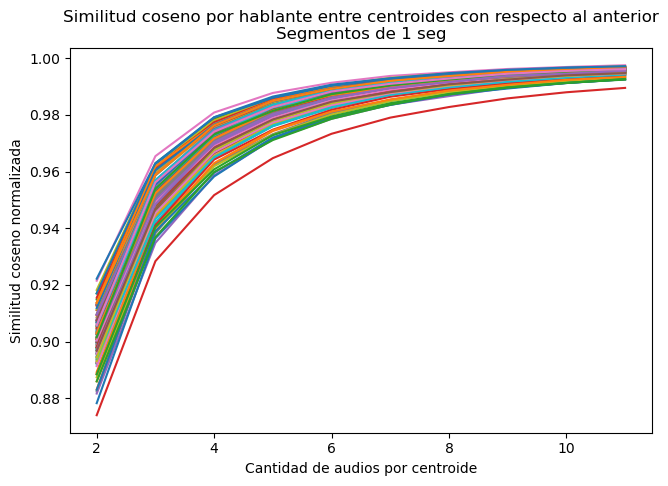

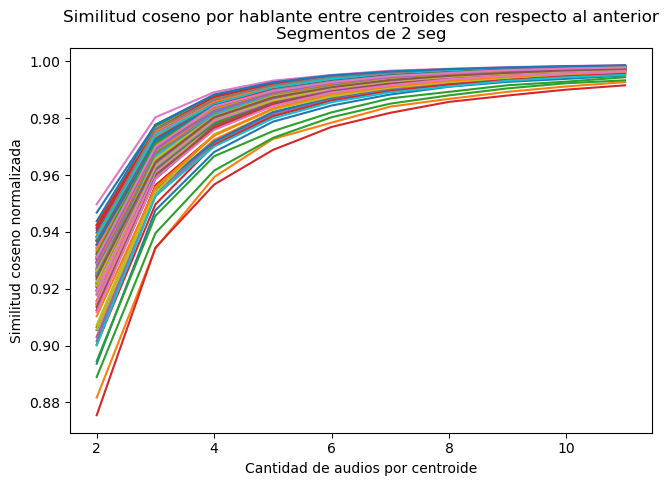

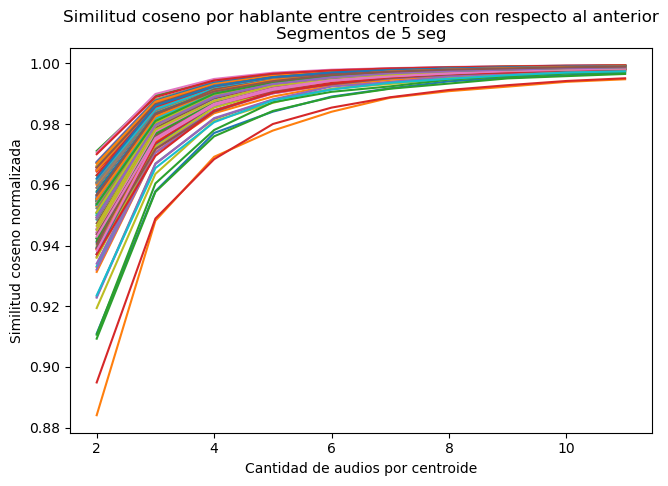

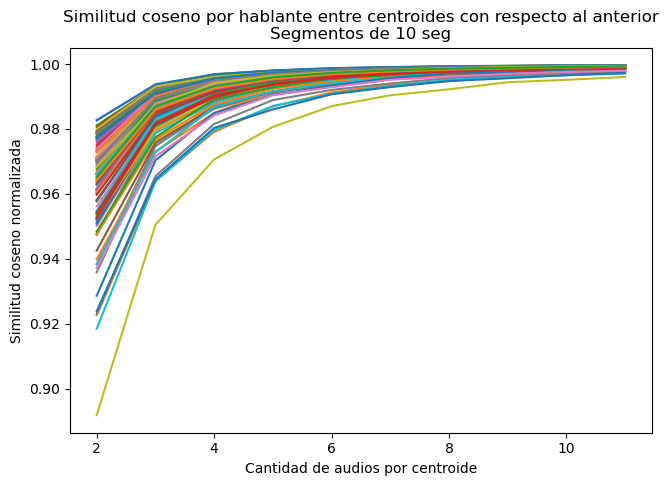

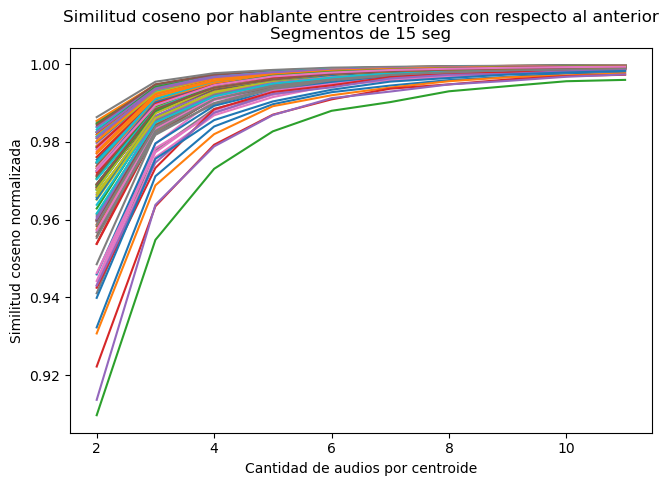

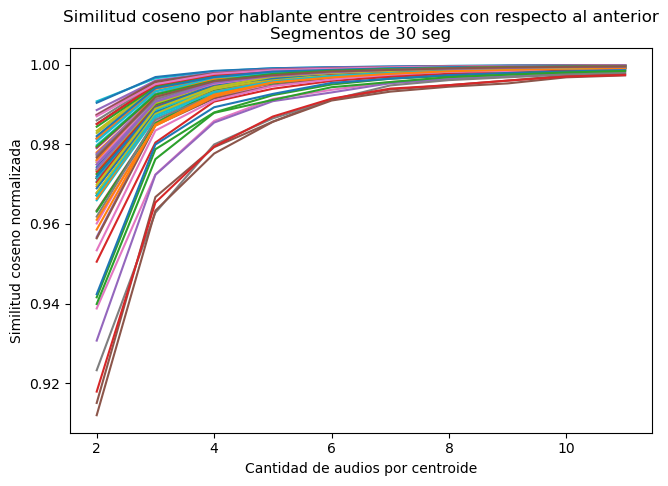

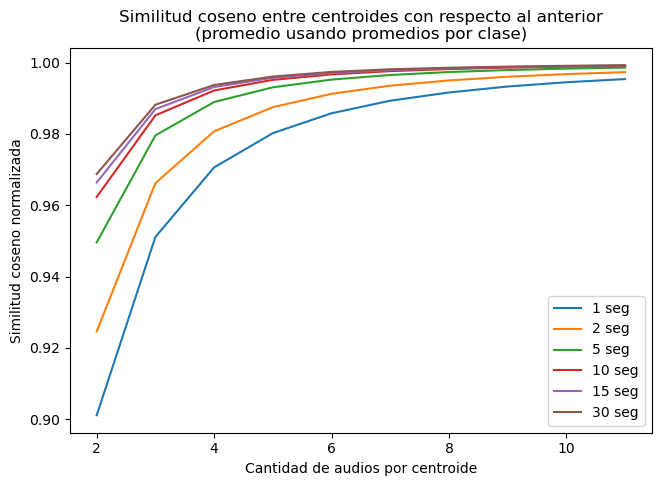

In [10]:
plot_centroid_evolution_by_duration(U, label_vectors, durations, T=10)

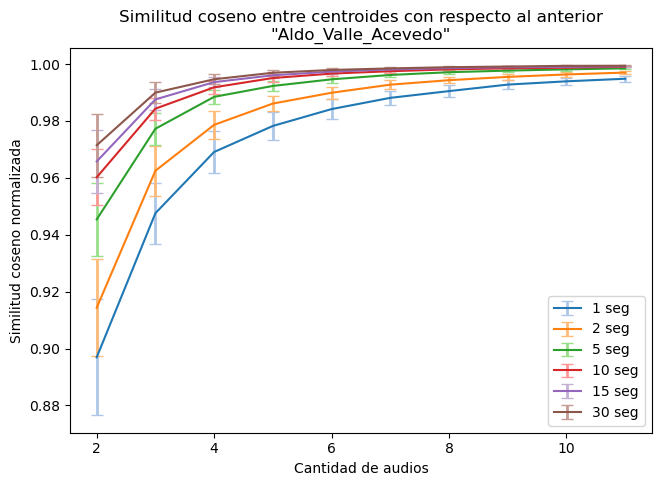

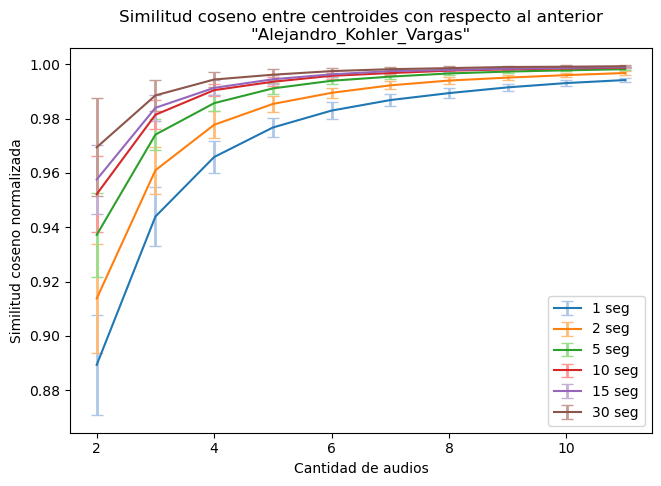

In [11]:
for label in COMMON_LABELS[:2]:
    # Example usage
    fig = plt.figure(figsize=(7.5, 5))
    ax = fig.add_subplot(1, 1, 1)  # Add an Axes to the figure if it doesn't exist
    aax = plot_centroid_evolution_by_label(ax, U, V, durations, label)

    plt.show()

In [65]:
U.shape

(6, 19, 127)

In [54]:
np.min(U[:,:, COMMON_LABELS])

numpy.float32

In [79]:
def plot_centroid_evolution_histogram(means: np.ndarray, stds: np.ndarray):
    """
    Plots a histogram for an element-wise feature in a sequence
    of centroid evolution.
    """
    means = means[:, :, COMMON_LABELS]
    max_mean = 1
    min_mean = np.min(means)
    bins_mean = np.linspace(min_mean, max_mean, 25)

    stds = stds[:, :, COMMON_LABELS]
    max_std = np.max(stds)
    min_std = 0
    bins_std = np.linspace(min_std, max_std, 25)

    _, K, _ = means.shape
    for k in range(K):
        mean = means[:, k, :]
        std = stds[:, k, :]
        
        # Plot histograms
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

        title = f"""Histogramas de la media y desviación estándar de la similitud coseno
        entre centroides {k+2} y {k+1}"""

        fig.suptitle(title)
        
        # Mean histogram
        ax1.set_title('Media')
        ax1.hist(mean[0], bins=bins_mean, alpha=0.5, label='1 seg', color='gray')
        ax1.hist(mean[1], bins=bins_mean, alpha=0.5, label='2 seg', color='yellow')
        ax1.hist(mean[2], bins=bins_mean, alpha=0.5, label='5 seg', color='blue')
        ax1.hist(mean[3], bins=bins_mean, alpha=0.5, label='10 seg', color='red')
        ax1.hist(mean[4], bins=bins_mean, alpha=0.5, label='15 sec', color='green')
        ax1.hist(mean[5], bins=bins_mean, alpha=0.5, label='30 seg', color='purple')
        
        ax1.set_xlabel('Media')
        ax1.set_ylabel('Frecuencia')
        ax1.legend(loc='upper left')


        # Standard deviation histogram
        ax2.set_title('Desviación estándar')
        ax2.hist(std[0], bins=bins_std, alpha=0.5, label='1 seg', color='gray')
        ax2.hist(std[1], bins=bins_std, alpha=0.5, label='2 seg', color='yellow')
        ax2.hist(std[2], bins=bins_std, alpha=0.5, label='5 seg', color='blue')
        ax2.hist(std[3], bins=bins_std, alpha=0.5, label='10 seg', color='red')
        ax2.hist(std[4], bins=bins_std, alpha=0.5, label='15 sec', color='green')
        ax2.hist(std[5], bins=bins_std, alpha=0.5, label='30 seg', color='purple')

        ax2.set_xlabel('Desviación estándar')
        ax2.set_ylabel('Frecuencia')
        ax2.legend(loc='upper right')

        # Showing plot
        plt.show()
        
    return bins_mean, bins_std

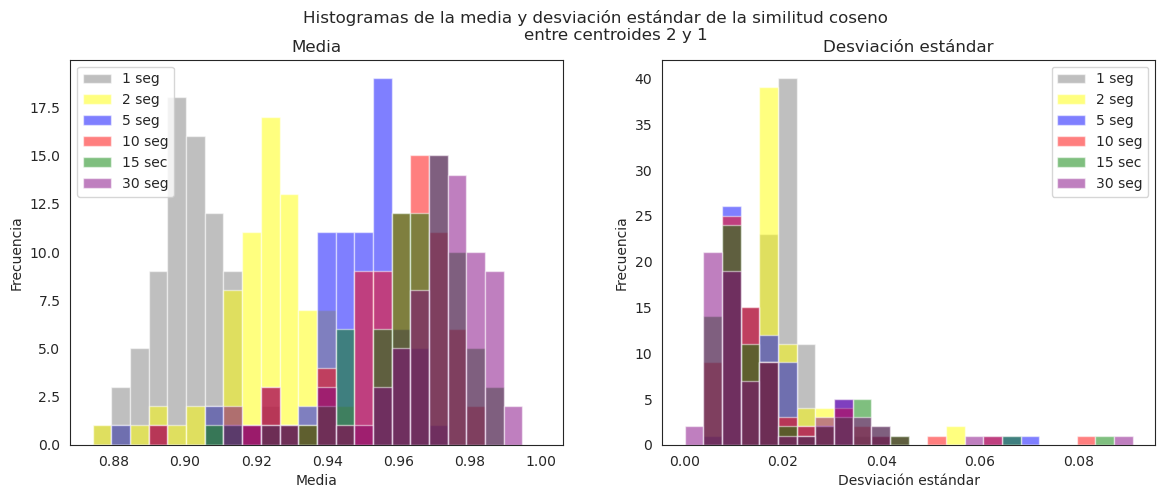

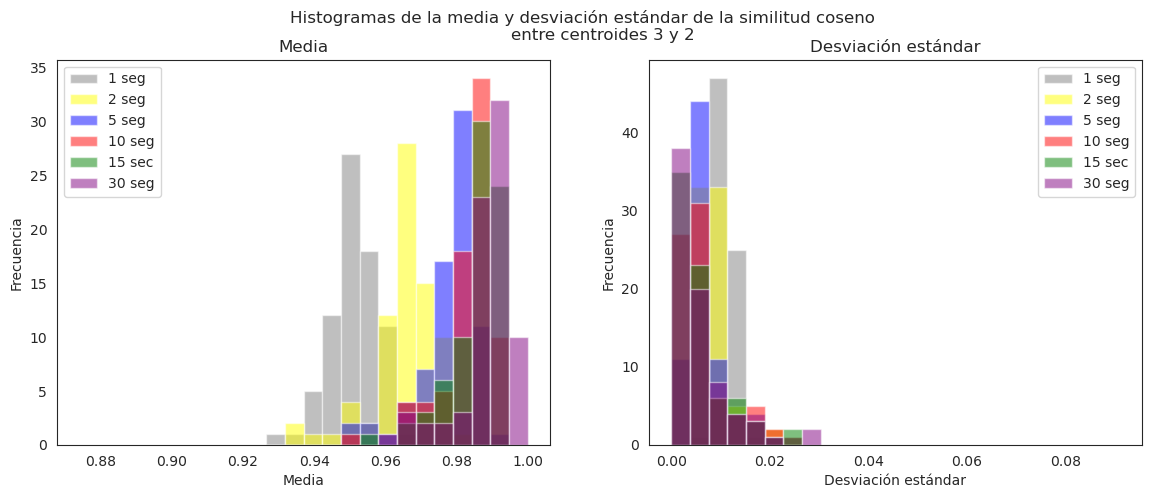

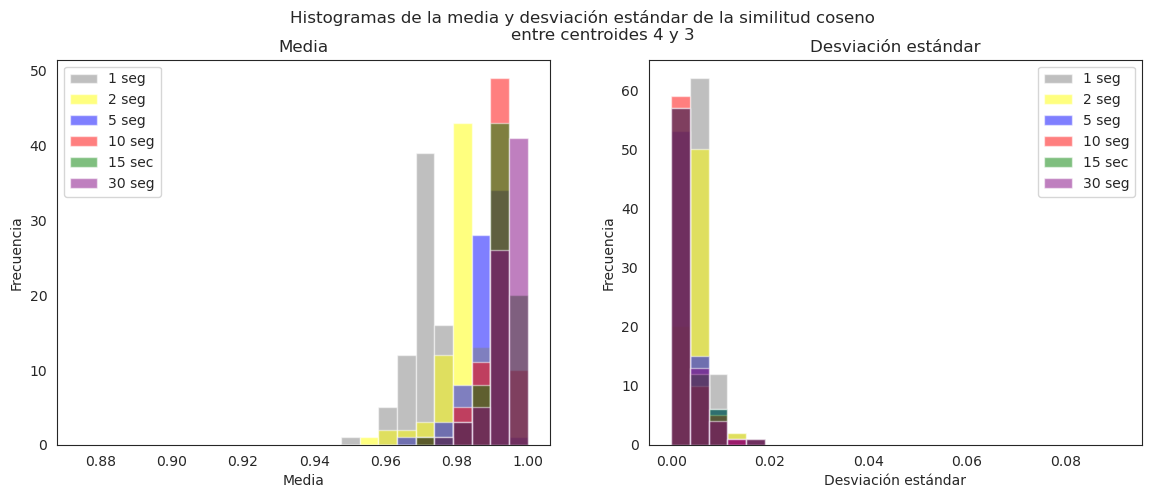

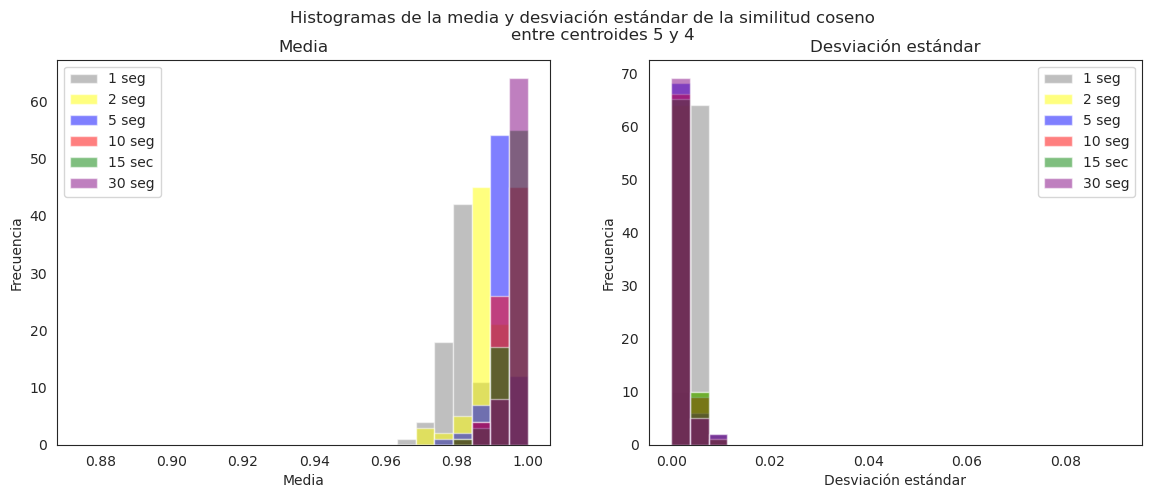

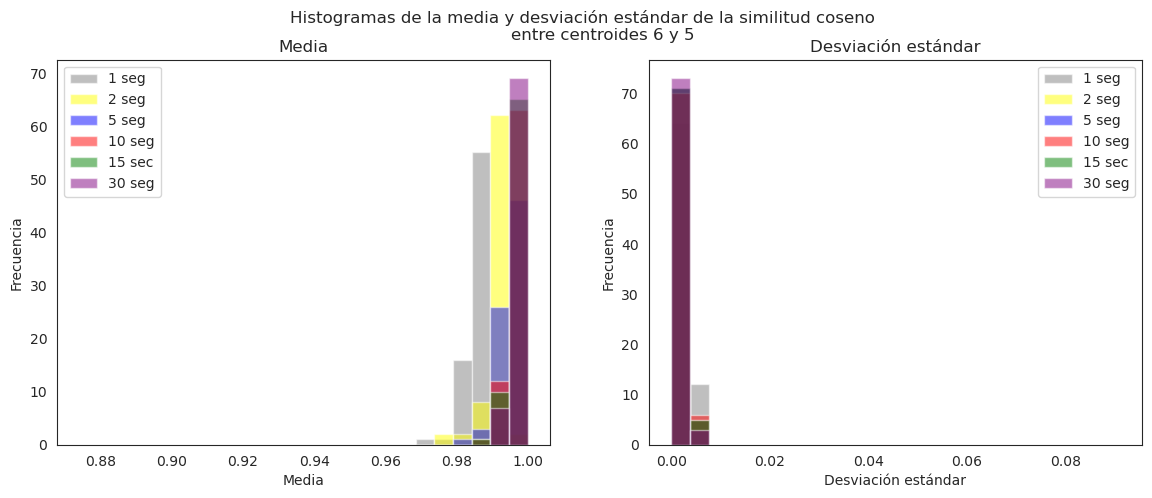

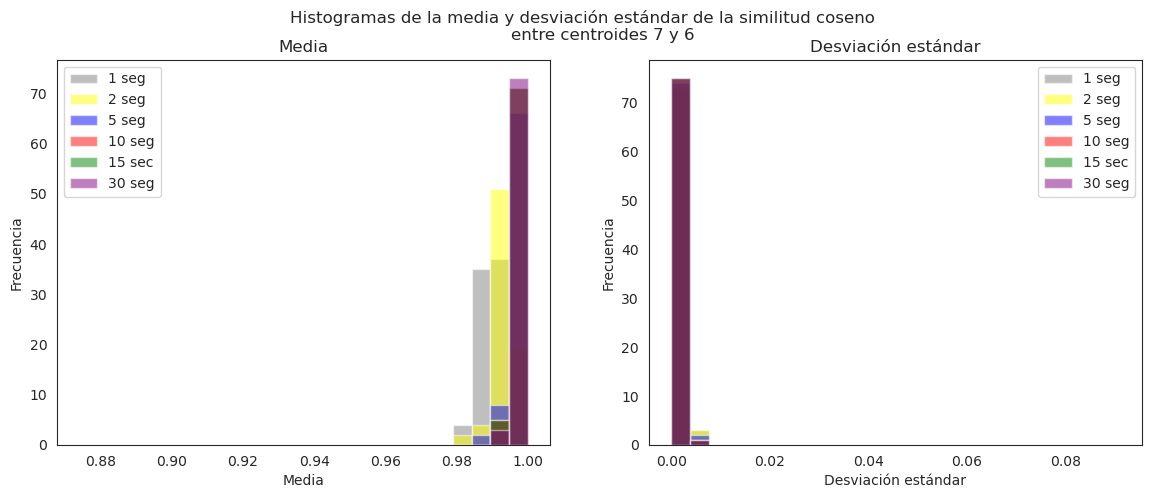

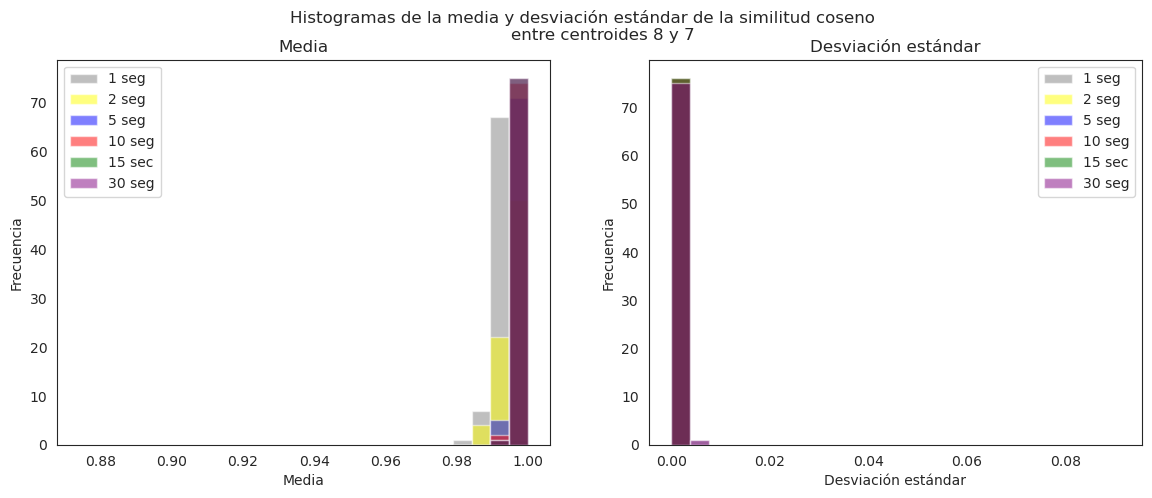

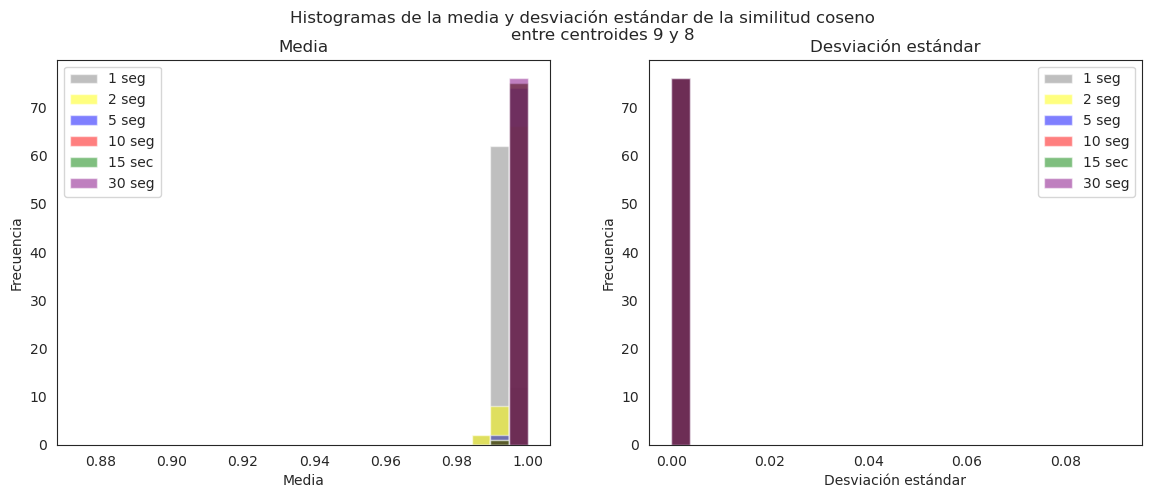

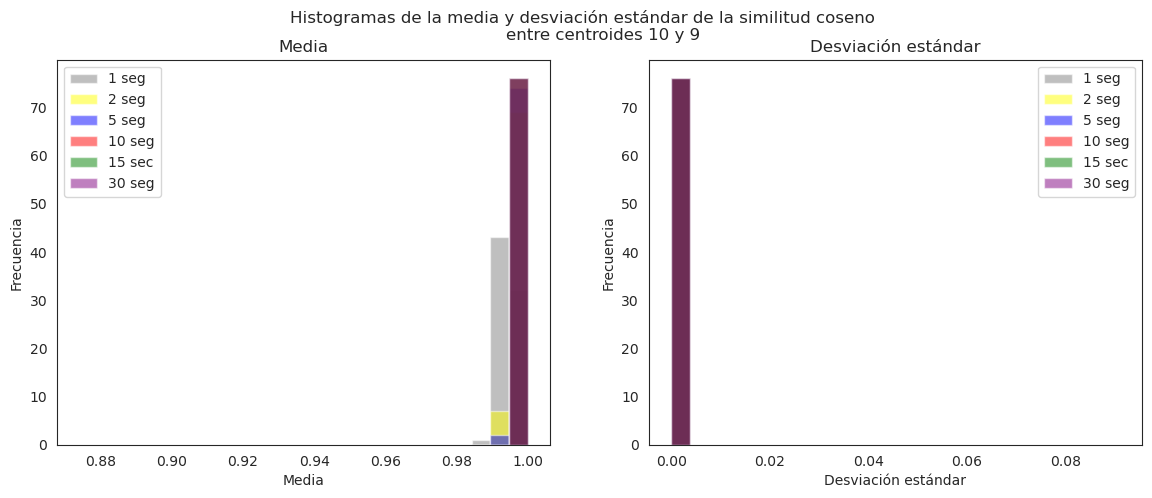

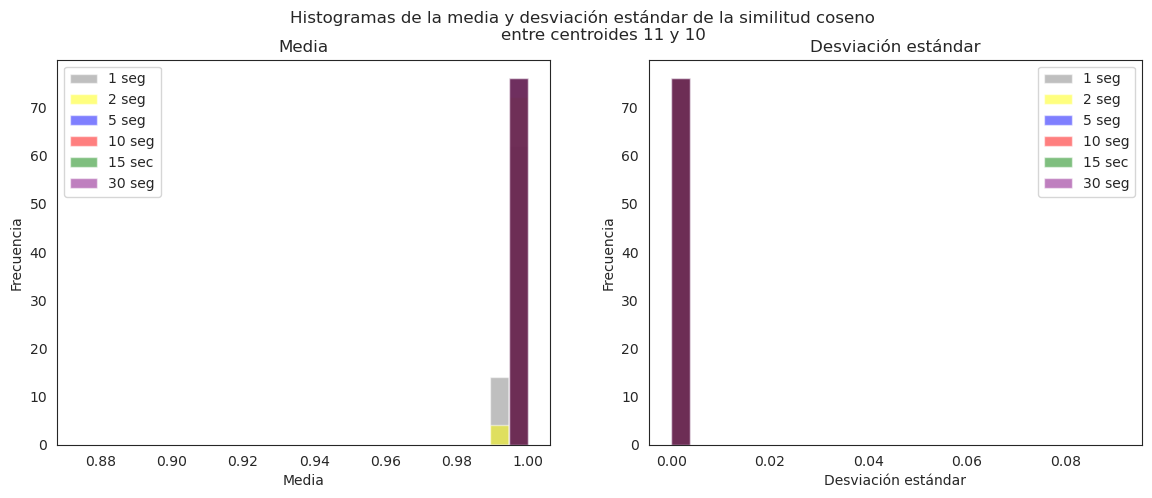

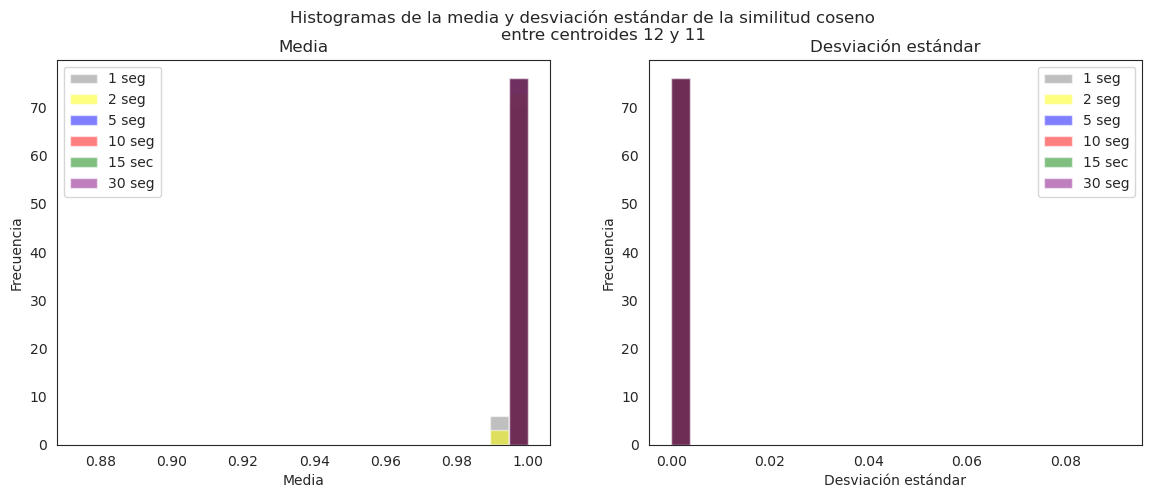

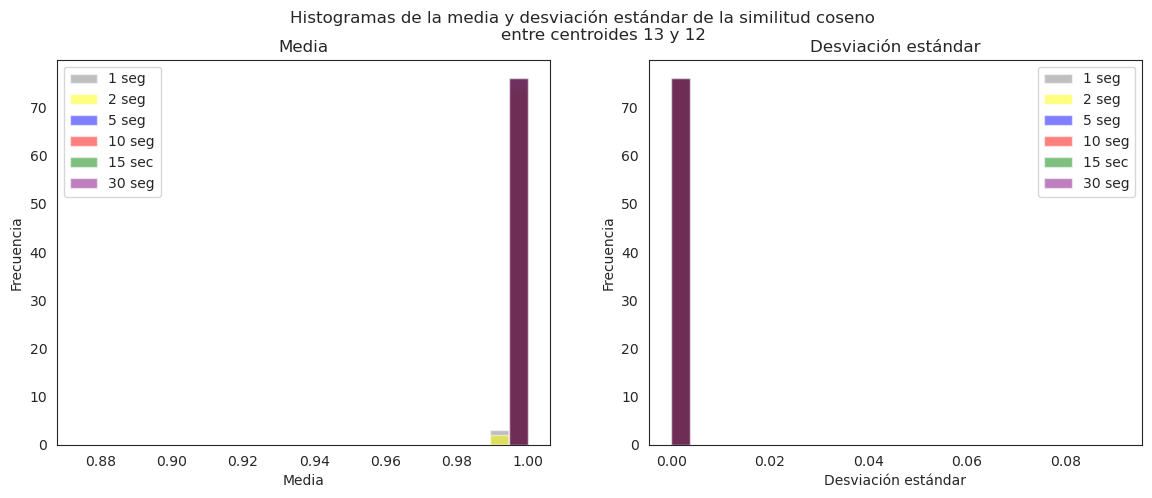

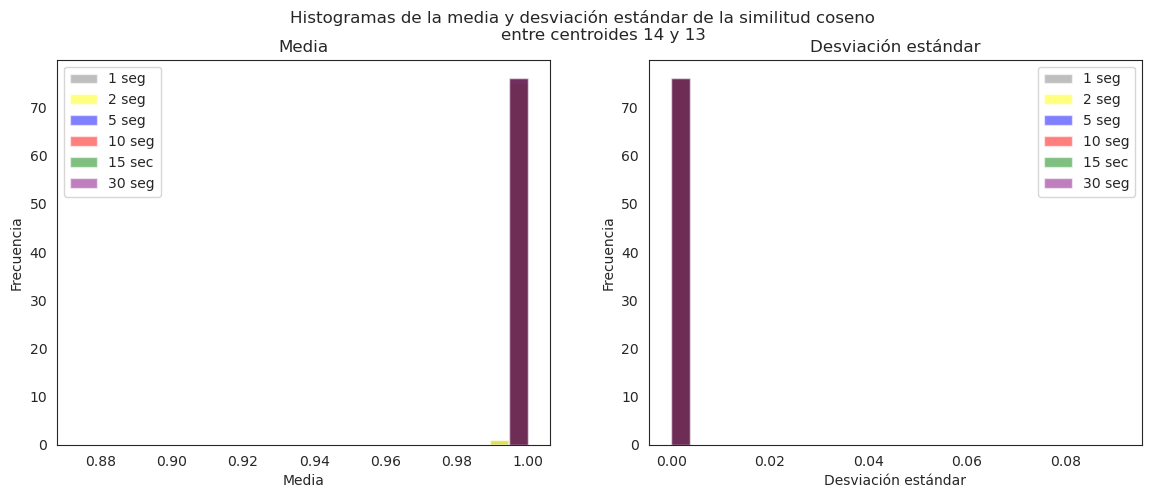

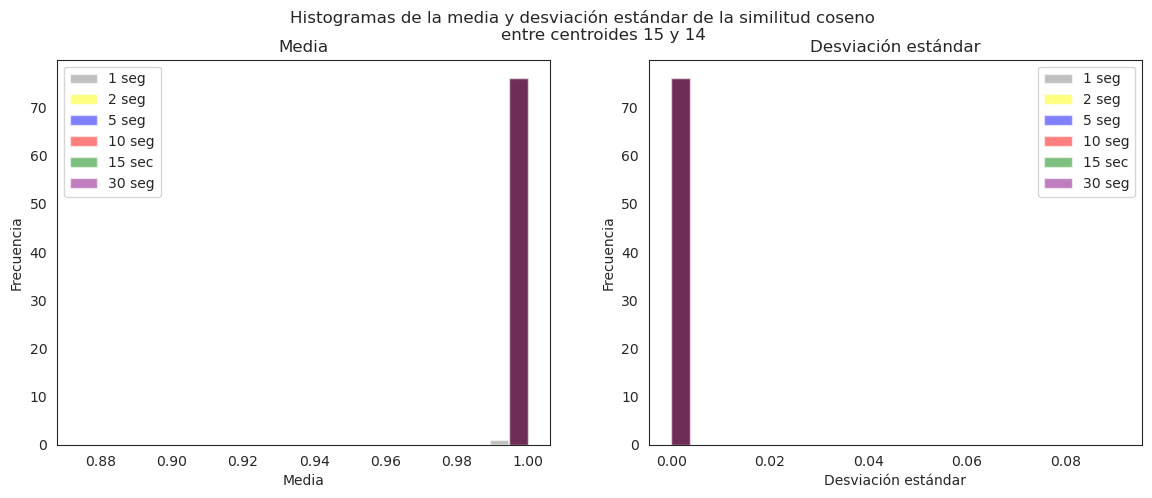

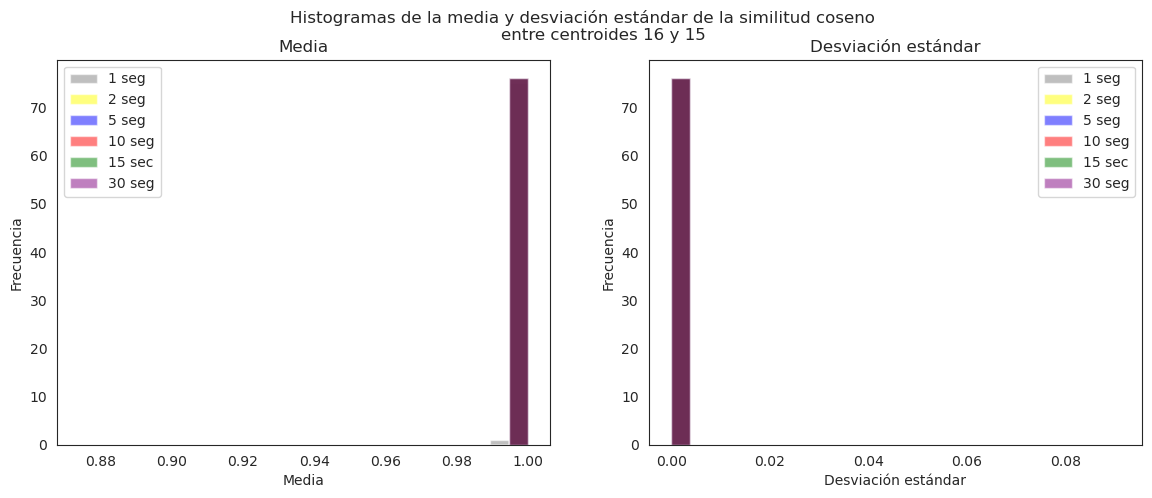

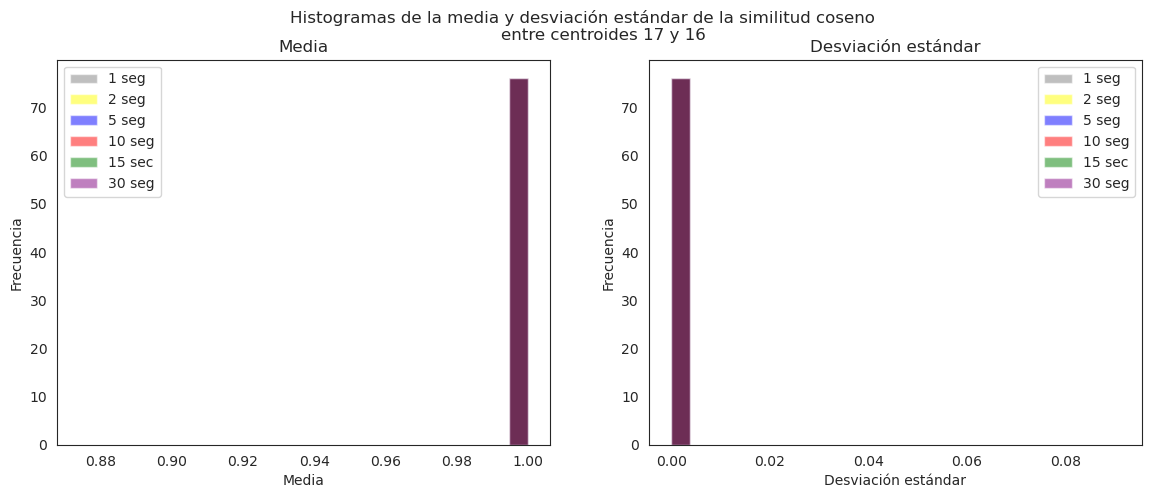

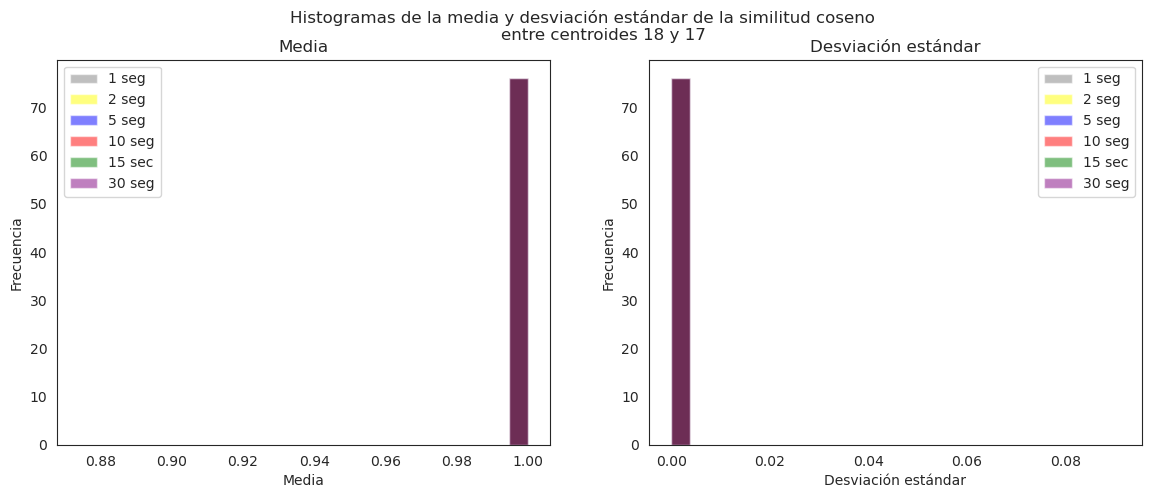

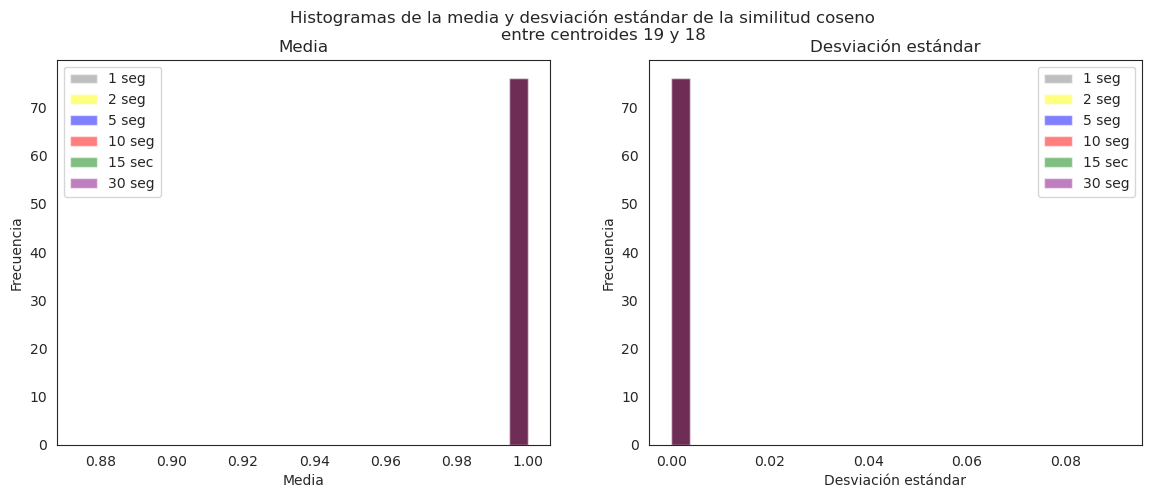

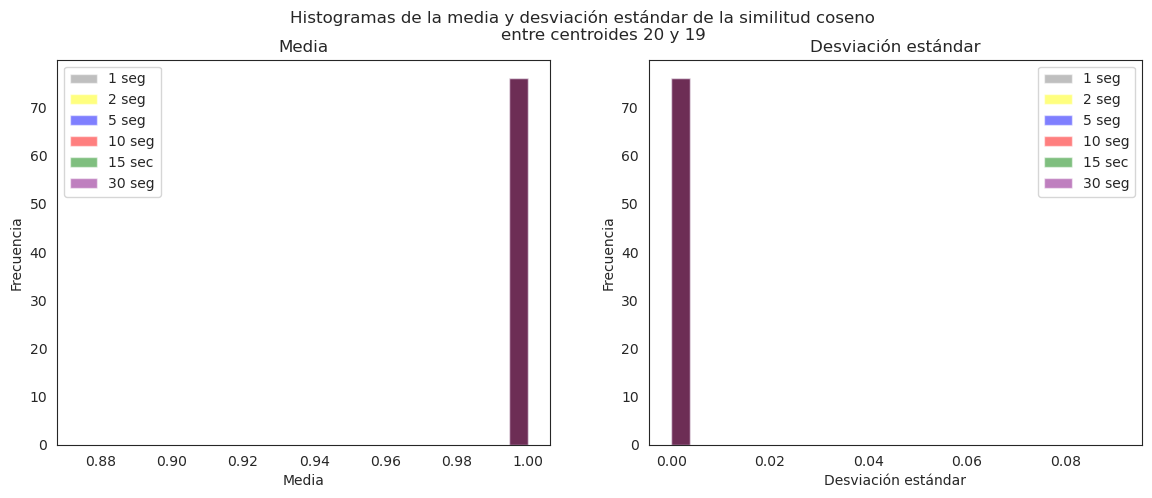

(array([0.87403452, 0.87928309, 0.88453165, 0.88978021, 0.89502877,
        0.90027733, 0.90552589, 0.91077445, 0.91602302, 0.92127158,
        0.92652014, 0.9317687 , 0.93701726, 0.94226582, 0.94751438,
        0.95276295, 0.95801151, 0.96326007, 0.96850863, 0.97375719,
        0.97900575, 0.98425432, 0.98950288, 0.99475144, 1.        ]),
 array([0.        , 0.00379437, 0.00758875, 0.01138312, 0.0151775 ,
        0.01897187, 0.02276625, 0.02656062, 0.030355  , 0.03414937,
        0.03794375, 0.04173812, 0.04553249, 0.04932687, 0.05312124,
        0.05691562, 0.06070999, 0.06450437, 0.06829874, 0.07209312,
        0.07588749, 0.07968187, 0.08347624, 0.08727062, 0.09106499]))

In [80]:
plot_centroid_evolution_histogram(U,V)

### Stationary State

In [12]:
def compare_last_centroids_by_duration(centroids: np.ndarray, duration: List[int]):
    """
    
    """
    last_centroids = np.empty((len(LABELS), len(duration), 192))
    for i in COMMON_LABELS:
        for d in range(len(centroids)):
            last_centroids[i][d] = centroids[d][i][-1]

    Sc_stationary = np.empty((len(LABELS), len(duration), len(duration)))
    for i in COMMON_LABELS:
        for j in range(len(duration)):
            for k in range(len(duration)):
                Sc_stationary[i][j][k] = cosine_similarity(last_centroids[i][j], last_centroids[i][k])

    return Sc_stationary

def plot_last_centroids_similarity(Sc_stationary: np.ndarray, durations: List[int], n: int = None):
    """
    
    """
    sns.set_style('white')
    mask = np.triu(np.ones_like(Sc_stationary[0], dtype=bool))
    durations_s = [f"{d} seg" for d in durations]

    for i, label in enumerate(COMMON_LABELS):
        if n is not None and i >= n:
            break
        plt.figure(figsize=(7.5, 5))
        plt.title(f'Similitud coseno entre centroides finales\n"{LABELS[label]}"')
        sns.heatmap(Sc_stationary[label], cmap="viridis",
                    cbar_kws={'label': 'Similitud coseno normalizada'},
                    square=True, mask=mask,
                    xticklabels=durations_s, yticklabels=durations_s,
                    vmin=0.7, vmax=1)
        plt.show()

def hist_last_centroids_similarity(Sc_stationary: np.ndarray):
    """
    
    """
    sims = []
    mask = np.triu(np.ones_like(Sc_stationary[0], dtype=bool) ^ np.eye(6, dtype=bool))
    for i in COMMON_LABELS:
        sims.append(Sc_stationary[i][mask])  # Append all pairs of similarities
    sims = np.array(sims).flatten()
    
    # Calculate the histogram
    counts, bins = np.histogram(sims, bins=np.arange(0.65, 1.01, 0.025))
    
    # Calculate percentages
    percentages = counts / np.sum(counts) * 100
    
    sns.set_style('whitegrid')
    
    # Linear scale histogram with percentages
    plt.figure(figsize=(8, 5))
    plt.title(f'Histograma de similitud coseno entre centroides finales\nde un mismo hablante para distintas duraciones\n(Escala lineal)')
    plt.xlabel('Similitud coseno normalizada')
    plt.ylabel('Frecuencia')
    
    plt.bar(bins[:-1], counts, width=0.025, align='edge', alpha=0.6, label='Percentage')
    
    for bin_edge, cnt, pct in zip(bins[:-1], counts, percentages):
        plt.text(bin_edge + 0.0125, cnt, f'{pct:.2f}%', ha='center', va='bottom', fontsize=8)
    
    plt.show()

    # Log scale histogram
    plt.figure(figsize=(8, 5))
    plt.title(f'Histograma de similitud coseno entre centroides finales\nde un mismo hablante para distintas duraciones\n(Escala logarítmica)')
    plt.xlabel('Similitud coseno normalizada')
    plt.ylabel('log10(Frecuencia)')

    counts_log = counts.copy()
    counts_log[counts_log == 0] = 1  # Avoid calculation of log(0)

    plt.stairs(np.log10(counts_log), bins, fill=True, alpha=0.5)  # Plot the histogram in log scale
    plt.show()
    
    return sims, counts, bins

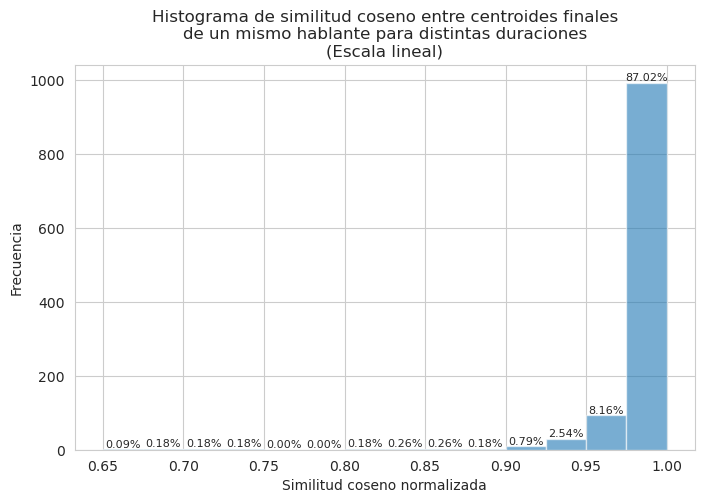

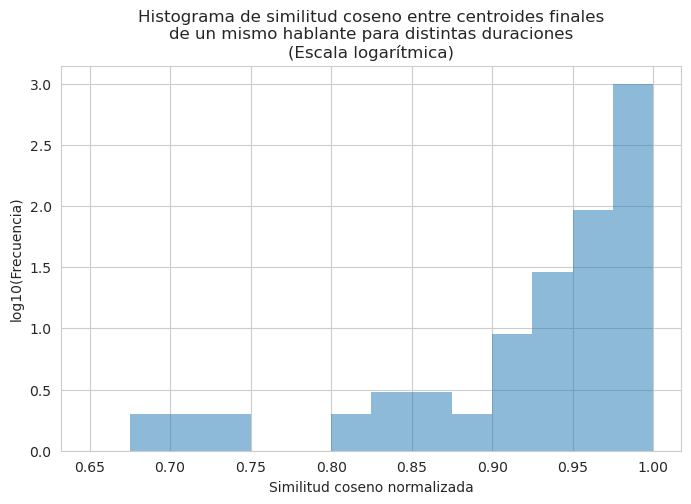

In [13]:
Sc_stationary = compare_last_centroids_by_duration(C, durations)
sims, counts, bins = hist_last_centroids_similarity(Sc_stationary)

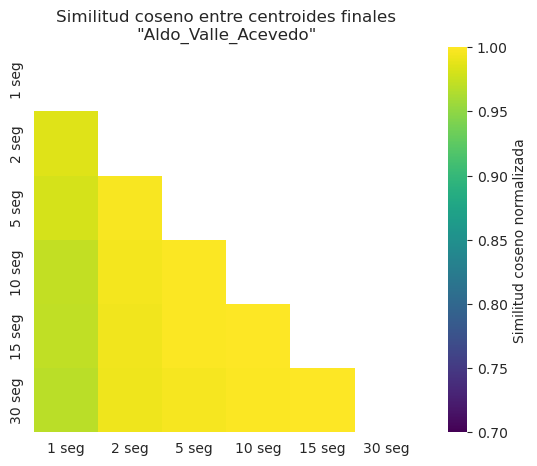

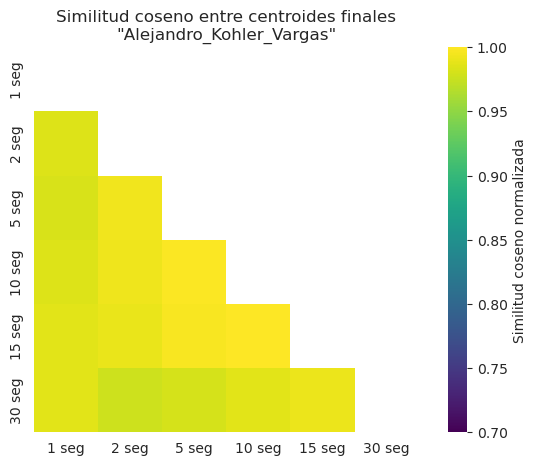

In [17]:
plot_last_centroids_similarity(Sc_stationary, durations, 2)

In [ ]:
# male = [
#  'Alejandro_Kohler_Vargas',
#  'Alihuen_Antileo_Navarrete',
#  'Carlos_Frontaura_Rivera',
#  'Diego_Vargas_Castillo',
#  'Domingo_Lovera_Parmo',
#  'Fernando_Viveros_Reyes',
#  'Hector_Urban_Astete',
#  'Invitado_Carlos_Mora',
#  'Invitado_Claudio_Alvarado',
#  'Invitado_Claudio_Orrego',
#  'Invitado_Enrique_Navarro_Beltran',
#  'Invitado_Gabriel_Bocksang',
#  'Invitado_Gonzalo_Garcia',
#  'Invitado_Javier_Coussot_Salas',
#  'Invitado_Jose_Montt',
#  'Invitado_Juan_Ignacio_Gonzalez',
#  'Invitado_Leonardo_Moreno',
#  'Invitado_Mijail_Bonito',
#  'Invitado_Nicolas_Enteiche',
#  'Invitado_Pablo_Aranda',
#  'Jaime_Arancibia_Mattar',
#  'Jorge_Ossandon_Spoerer',
#  'Luis_Silva_Irarrazaval',
#  'Maximo_Francisco_Pavez_Cantillano',
#  'Miguel_Littin_Cucumides',
#  'Miguel_Rojas_Soto',
#  'Sebastian_Figueroa_Melo',
#  'Secretario_Reynaldo_Nunez',
#  'Yerko_Ljubetic_Godoy']

# female = [
#  'Antonia_Rivas_Palma',
#  'Beatriz_Hevia_Willer',
#  'Carmen_Montoya_Mayorga',
#  'Carolina_Navarrete_Rubio',
#  'Catalina_Adriana_Lagos_Tschorne',
#  'Invitada_Antonia_Polanco',
#  'Invitada_Carmen_Dominguez',
#  'Invitada_Cecilia_Jara',
#  'Invitada_Giannina_Mondino',
#  'Invitada_Javiera_Diaz',
#  'Invitada_Josefa_Balmaceda',
#  'Invitada_Lidia_Casas',
#  'Invitada_Paola_Vega',
#  'Invitada_Rosario_Vidal',
#  'Ivonne_Mangelsdorff_Galeb',
#  'Karen_Araya_Rojas',
#  'Katherine_Denisse_Martorell_Awad',
#  'Kinturay_Melin_Rapiman',
#  'Leslie_Sanchez_Lobos',
#  'Lorena_Gallardo_Cardenas',
#  'Magaly_Fuenzalida_Colombo',
#  'Marcela_Araya_Sepulveda',
#  'Marcela_Ines_Peredo_Rojas',
#  'Maria_Gatica_Gajardo',
#  'Maria_de_los_Angeles_Lopez_Porfiri',
#  'Mariela_Fincheira_Massardo',
#  'Secretaria_Maria_Soledad_Fredes',
#  'Veronica_Undurraga_Valdes']

In [81]:
# plt.figure(figsize=(7.5, 5))
# plt.plot([3], [0.99], label='Masculino', c='orange')
# plt.plot([3], [0.99], label='Femenino',c='purple')
# for label in common_labels:
#     color = 'orange' if label in male else 'purple'
#     plt.plot(idx[:16], sims_df[f'{label}_mean'][:16], color, alpha=0.8)
#     plt.xlabel('Cantidad de audios')
#     plt.ylabel('Similitud coseno normalizada')
#     plt.title(f'Similitud coseno entre centroides sucesivos')
#     plt.legend(title='Género', loc='lower right')

---
## 3) Interclass Centroid Evolution

In [83]:
C.shape

(6, 127, 20, 192)

In [ ]:
def get_interclass_similarities(centroids: np.ndarray):
    """
    Computes the cosine similarity between the centroids of different classes for
    each of the K iterations.
    """
    N, K, _ = centroids.shape  # N speakers, K iterations, D dimensions
    interclass_similarities = np.zeros((K, N, N))

    for k in range(K):
        centroids_k = centroids[:, k]
        for i in range(N):
            for j in range(N):
                sim = cosine_similarity(centroids_k[i], centroids_k[j])
                interclass_similarities[k, i, j] = sim

    return interclass_similarities

def plot_max_interclass_similarity(interclass_similarities: np.ndarray):
    """
    Plots the maximum interclass similarity for each iteration.
    """
    K = interclass_similarities.shape[0]
    # Calculate the maximum difference between each pair of iterations
    M = []
    for k in range(K-1):
        m = np.max(abs(interclass_similarities[k] - interclass_similarities[k+1]))
        M.append(m)

    plt.figure(figsize=(7.5, 5))
    plt.title('Máxima diferencia entre similitudes coseno interclase por iteración con respecto a la anterior')
    plt.xlabel('Cantidad de audios')
    plt.ylabel('Diferencia máxima (valor absoluto)')
    plt.plot(np.arange(2, K+1), M)
    plt.show()

In [ ]:
centroids[0].shape

(127, 20, 192)

/tmp/ipykernel_935549/915035513.py:9: RuntimeWarning: divide by zero encountered in scalar divide
  cosine_similarity = dot_product / (norm_vec1 * norm_vec2)
/tmp/ipykernel_935549/915035513.py:9: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity = dot_product / (norm_vec1 * norm_vec2)
/tmp/ipykernel_935549/3351750557.py:26: RuntimeWarning: invalid value encountered in subtract
  m = np.max(abs(interclass_similarities[k] - interclass_similarities[k+1]))


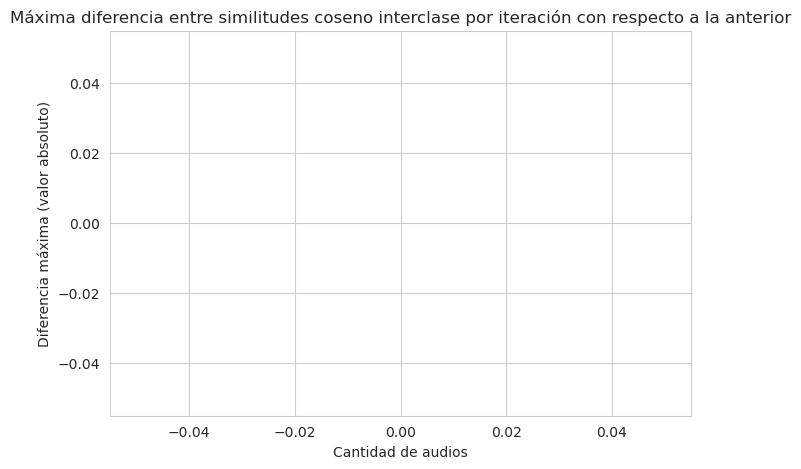

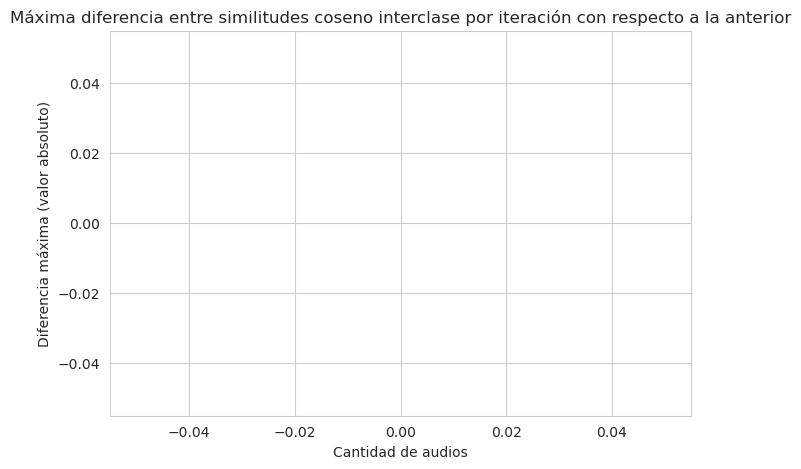

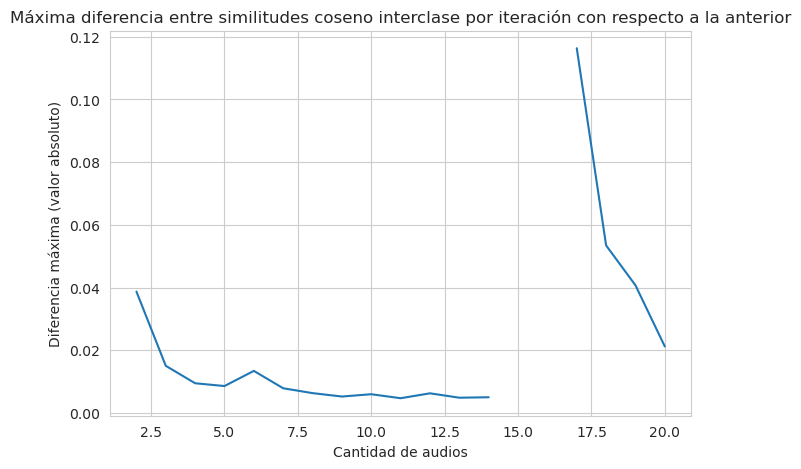

/tmp/ipykernel_935549/915035513.py:9: RuntimeWarning: invalid value encountered in scalar multiply
  cosine_similarity = dot_product / (norm_vec1 * norm_vec2)


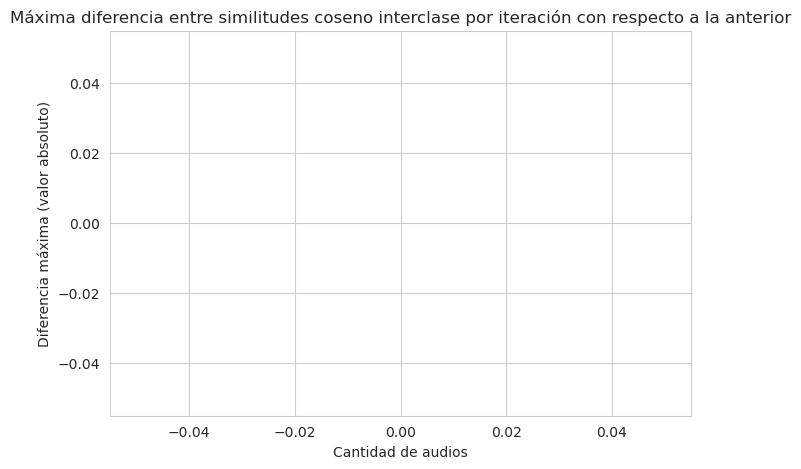

In [ ]:
for i in range(len(centroids)):    
    interclass_similarities = get_interclass_similarities(centroids[i])
    plot_max_interclass_similarity(interclass_similarities)
    

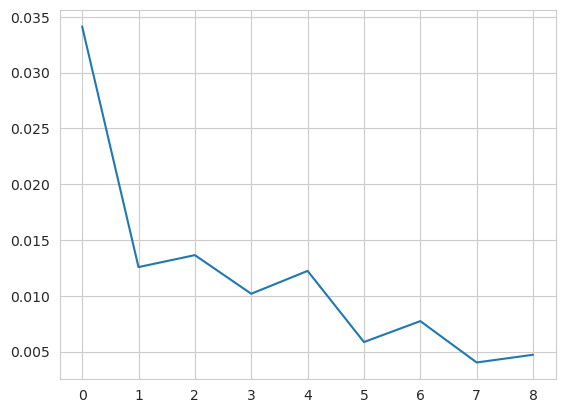

In [ ]:
# Calculate the maximum difference between each pair of iterations
M = []
index = []
for k in range(K-1):
    m = np.max(abs(interclass_similarities[k] - interclass_similarities[k+1]))
    M.append(m)
    index.append(k)

plt.plot(index, M)

/tmp/ipykernel_3225/915035513.py:9: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity = dot_product / (norm_vec1 * norm_vec2)


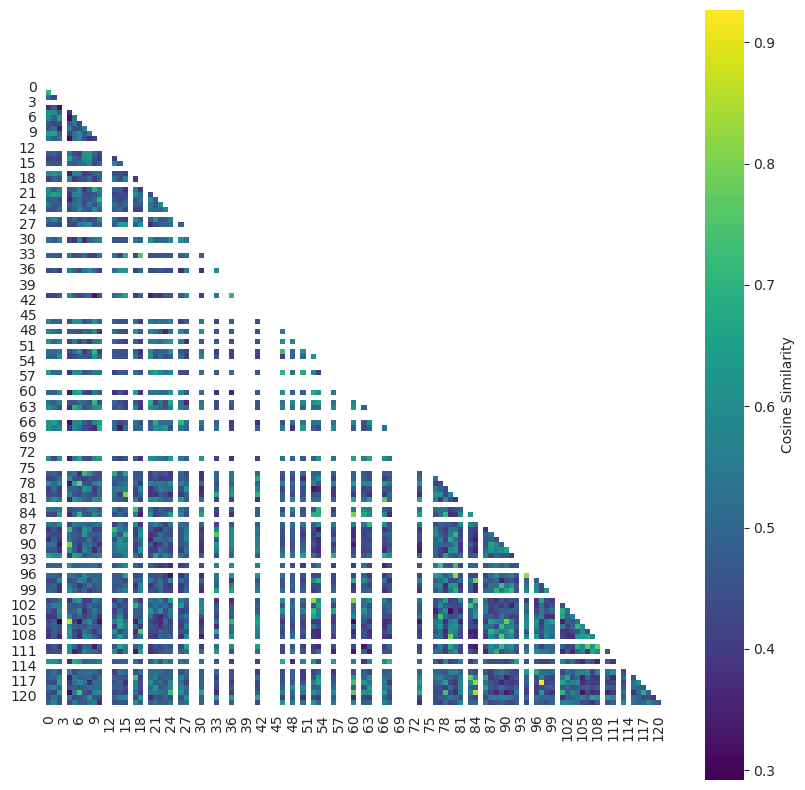

In [ ]:
# Create a mask for the upper triangle
interclass_similarities = get_interclass_similarities(centroids[-1])
m = interclass_similarities[-1]

mask = np.triu(np.ones_like(m, dtype=bool))
plt.figure(figsize=(10, 10))
# Set the upper triangle to NaN
# m[mask] = np.nan
sns.set_style('white')
sns.heatmap(m, cmap="viridis", cbar_kws={'label': 'Cosine Similarity'}, mask=mask, square=True)

plt.show()

In [ ]:
m[mask]

NameError: name 'm' is not defined

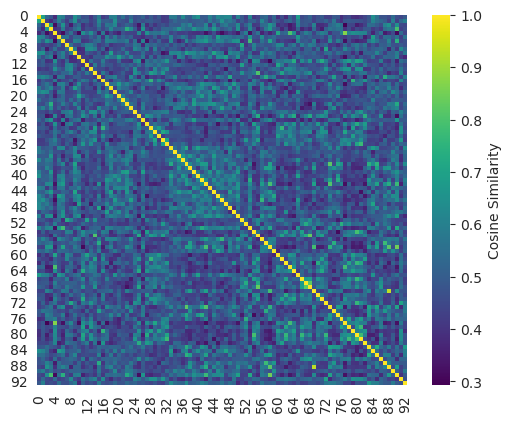

In [ ]:
sns.heatmap(interclass_similarities[-1], cmap="viridis", cbar_kws={'label': 'Cosine Similarity'}, square=True)
plt.show()

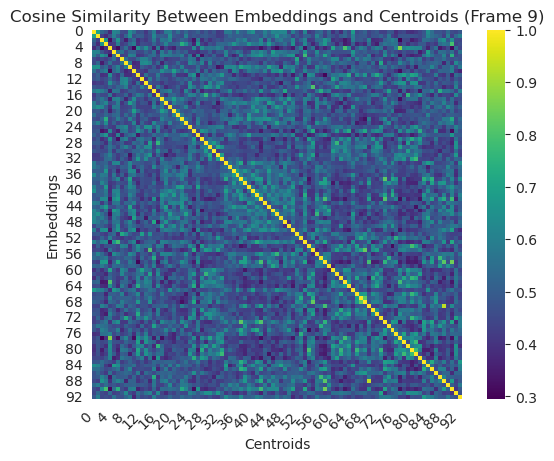

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Example data: List of 2D arrays representing heatmap data at different time points
# Assuming interclass_similarities is already defined as in your example

# Set up the figure and axis
fig, ax = plt.subplots()

# Create a mask for the upper triangle

# mask = np.triu(np.ones_like(m, dtype=bool))

# Initialize the heatmap
heatmap = sns.heatmap(interclass_similarities[0], cmap='viridis', square=True,
                      # mask=mask,
                      cbar=True, ax=ax)

# Set axis labels and title
ax.set_title('Cosine Similarity Between Embeddings and Centroids')
ax.set_xlabel('Centroids')
ax.set_ylabel('Embeddings')

# Customize tick labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

# Get the QuadMesh object from the heatmap
quadmesh = ax.collections[0]

# Function to update the heatmap
def update(k):
    quadmesh.set_array(interclass_similarities[k].flatten())
    ax.set_title(f'Cosine Similarity Between Embeddings and Centroids (Frame {k})')
    return quadmesh,

# Create the animation
ani = FuncAnimation(fig, update, frames=len(interclass_similarities), blit=False)

# Save the animation or display it
ani.save('heatmap_animation.mp4', writer='ffmpeg', fps=5)
plt.show()

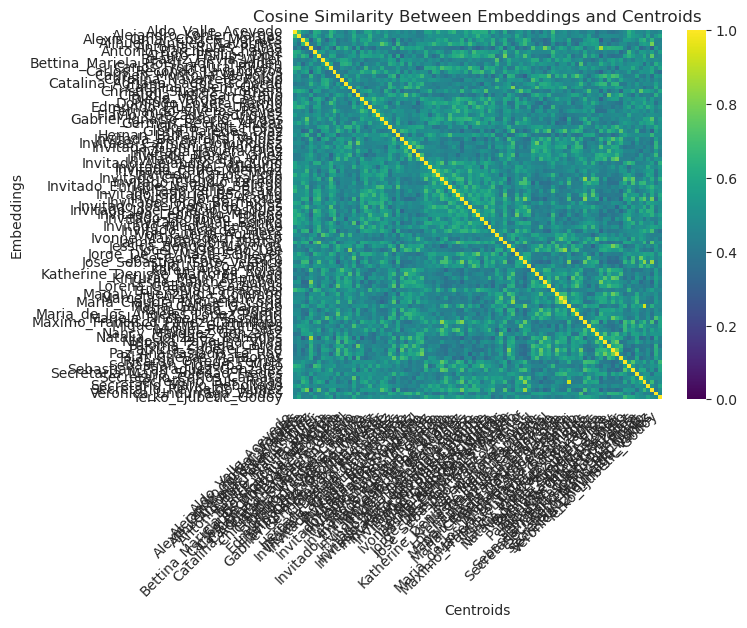

In [ ]:
ax = sns.heatmap(interclass_similarities[-1], cmap='viridis', square=True,
                 vmin=0, vmax=1, xticklabels=valid_labels, yticklabels=valid_labels)
ax.set_title('Cosine Similarity Between Embeddings and Centroids')
ax.set_xlabel('Centroids')
ax.set_ylabel('Embeddings')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

In [ ]:
centroids.shape
last_centroids = centroids[:, -1]
last_centroids.shape

(93, 192)

In [ ]:
last_centroids[0].shape

(192,)

In [ ]:
last_centroids = centroids[:, -1]
embedding_own_centroid = []

for n in range(N):
    speaker_embs = embeddings[labels == n]
    cen = last_centroids[n]
    for emb in speaker_embs:
        sim = cosine_similarity(emb, cen)
        embedding_own_centroid.append(sim)

embedding_own_centroid = np.array(embedding_own_centroid)

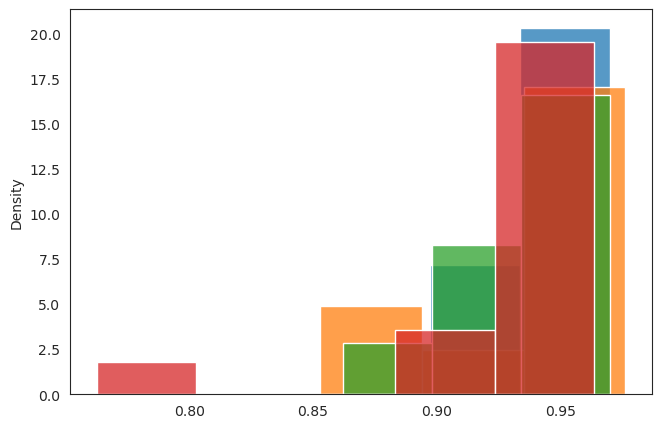

In [ ]:
plt.figure(figsize=(7.5, 5))

for n in range(4):
    speaker_embs = embedding_own_centroid[labels == n]
    sns.histplot(speaker_embs, stat='density', binwidth=0.04)


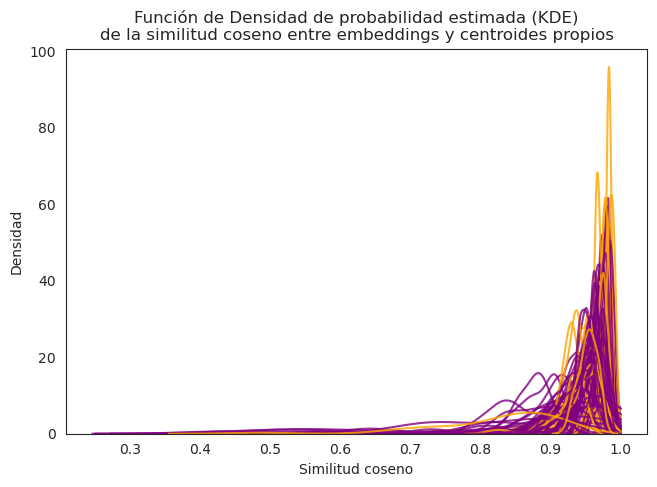

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(7.5, 5))

# Add a title and labels
plt.title('Función de Densidad de probabilidad estimada (KDE)\nde la similitud coseno entre embeddings y centroides propios')
plt.xlabel('Similitud coseno')
plt.ylabel('Densidad')
domain = (0,1)


for n in range(N):
    speaker = valid_labels[n]
    color = 'orange' if speaker in male else 'purple'
    speaker_embs = embedding_own_centroid[labels == n]
    # Create a KDE plot
    
    sns.kdeplot(speaker_embs, bw_adjust=1, fill=False, clip=domain, color=color, alpha=0.8)
# Show the plot
plt.show()

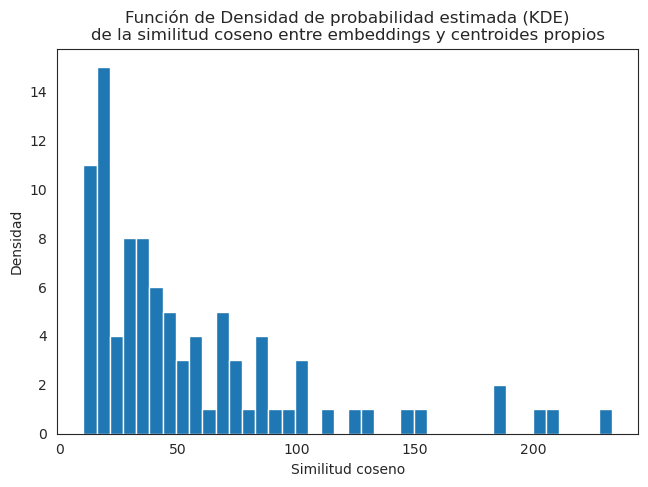

In [ ]:
plt.figure(figsize=(7.5, 5))

# Add a title and labels
plt.title('Función de Densidad de probabilidad estimada (KDE)\nde la similitud coseno entre embeddings y centroides propios')
plt.xlabel('Similitud coseno')
plt.ylabel('Densidad')
domain = (0,1)

a = [i for i in range(N)]
counts = [np.sum(labels == n) for n in range(N)]

bins = plt.hist(counts, bins=40)
plt.show()

In [ ]:
bins

(array([11., 15.,  4.,  8.,  8.,  6.,  5.,  3.,  4.,  1.,  5.,  3.,  1.,
         4.,  1.,  1.,  3.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  1.,  1.,
         0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,
         1.]),
 array([ 10.   ,  15.575,  21.15 ,  26.725,  32.3  ,  37.875,  43.45 ,
         49.025,  54.6  ,  60.175,  65.75 ,  71.325,  76.9  ,  82.475,
         88.05 ,  93.625,  99.2  , 104.775, 110.35 , 115.925, 121.5  ,
        127.075, 132.65 , 138.225, 143.8  , 149.375, 154.95 , 160.525,
        166.1  , 171.675, 177.25 , 182.825, 188.4  , 193.975, 199.55 ,
        205.125, 210.7  , 216.275, 221.85 , 227.425, 233.   ]),
 <BarContainer object of 40 artists>)

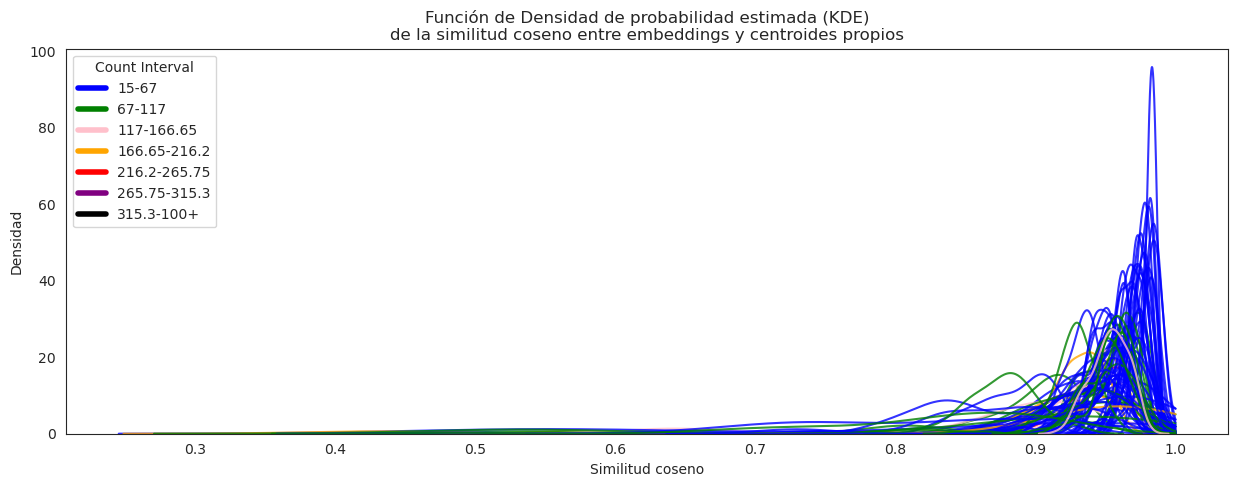

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(15, 5))

# Add a title and labels
plt.title('Función de Densidad de probabilidad estimada (KDE)\nde la similitud coseno entre embeddings y centroides propios')
plt.xlabel('Similitud coseno')
plt.ylabel('Densidad')
domain = (0, 1)

# Define intervals and their corresponding colors
intervals = [
    (15, 67, 'b'),
    (67, 117, 'g'),
    (117, 166.65, 'pink'),
    (166.65, 216.2 , 'orange'),
    (216.2 , 265.75, 'r'),
    (265.75, 315.3 , 'purple'),
    # (60, 70, 'brown'),
    # (70, 80, 'pink'),
    # (80, 90, 'cyan'),
    # (90, 100, 'm'),
    (315.3 , float('inf'), 'k')  # Catch-all for counts >= 100
]

# Plot KDE with colors based on the count interval
for n in range(N):
    speaker = valid_labels[n]
    count = np.sum(labels == n)
    for start, end, color in intervals:
        if start <= count < end:
            speaker_embs = embedding_own_centroid[labels == n]
            sns.kdeplot(speaker_embs, bw_adjust=1, fill=False, clip=domain, color=color, alpha=0.8)
            break

# Create custom legend
handles = [plt.Line2D([0], [0], color=color, lw=4) for _, _, color in intervals]
lbls = [f'{start}-{end if end != float("inf") else "100+"}' for start, end, _ in intervals]
plt.legend(handles, lbls, title='Count Interval')

# Show the plot
plt.show()

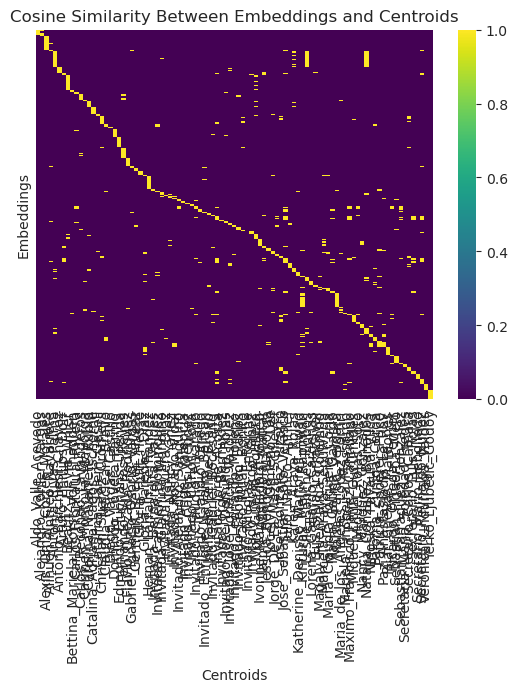

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# plt.figure(figsize=(20, 40))  # Adjust the size to handle the large matrix
ax = sns.heatmap(similarity_matrix >.7, cmap='viridis', xticklabels=embeddings_by_label.keys(), yticklabels=False)
ax.set_title('Cosine Similarity Between Embeddings and Centroids')
ax.set_xlabel('Centroids')
ax.set_ylabel('Embeddings')
plt.show()

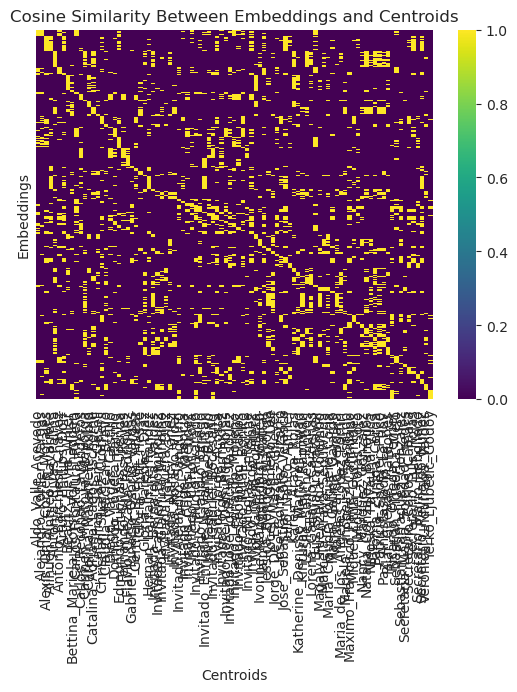

In [ ]:
# plt.figure(figsize=(20, 40))  # Adjust the size to handle the large matrix
ax = sns.heatmap(np.abs(similarity_matrix)>.6, cmap='viridis', xticklabels=embeddings_by_label.keys(), yticklabels=False)
ax.set_title('Cosine Similarity Between Embeddings and Centroids')
ax.set_xlabel('Centroids')
ax.set_ylabel('Embeddings')
plt.show()

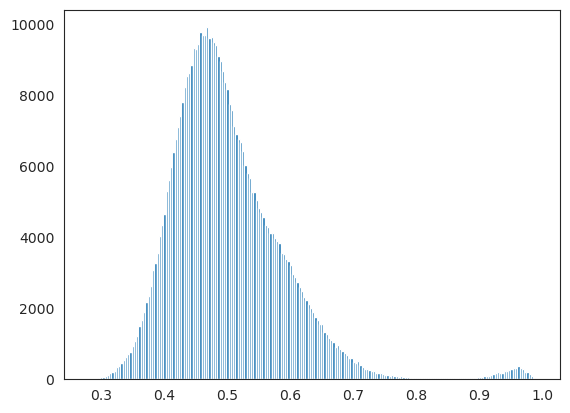

In [ ]:
plt.hist((similarity_matrix).reshape(-1), bins=200);
# plt.yscale("log")

In [ ]:
a = np.vstack(all_embeddings)

NameError: name 'all_embeddings' is not defined

In [ ]:
a

array([[-0.06897517, -0.05414196,  0.06097658, ..., -0.0272247 ,
         0.06051932, -0.04344228],
       [ 0.0395584 , -0.05582495,  0.04575963, ...,  0.03368031,
        -0.06320056, -0.01052512],
       [ 0.05373601, -0.01926537,  0.058074  , ..., -0.06986475,
        -0.1131865 , -0.0717617 ],
       ...,
       [ 0.0434302 , -0.01863375,  0.11141832, ...,  0.05687591,
        -0.01010055,  0.04494489],
       [ 0.07610386, -0.04430066,  0.05074406, ...,  0.08349352,
        -0.07788533,  0.02240222],
       [ 0.02174916, -0.01224554,  0.07873227, ...,  0.15053266,
        -0.0509986 ,  0.01316411]], dtype=float32)

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=2)
c = pca.fit_transform(np.log(np.abs(a)))

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
b = tsne.fit_transform(a)
a.shape

<ipython-input-69-ddf4dadee454>:3: RuntimeWarning: invalid value encountered in log
  b = tsne.fit_transform(np.log(a))


ValueError: Input X contains NaN.
TSNE does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 3.0 MB/s eta 0:00:00


In [ ]:
import umap

reducer = umap.UMAP()
u = reducer.fit_transform(a)


AttributeError: module 'umap' has no attribute 'UMAP'

In [ ]:
classes = [[e for _ in range(len(embeddings[e]))] for e in embeddings]
classes_result = []
for i in classes:
  classes_result += i
# Create a color map from unique string labels to colors
unique_classes = list(np.unique(classes_result))
colors = plt.cm.jet(np.linspace(0, 1, len(unique_classes)))  # Generate as many colors as there are unique classes
color_map = dict(zip(unique_classes, colors))

# Map the string labels to colors
class_colors = [color_map[cls] for cls in classes_result]


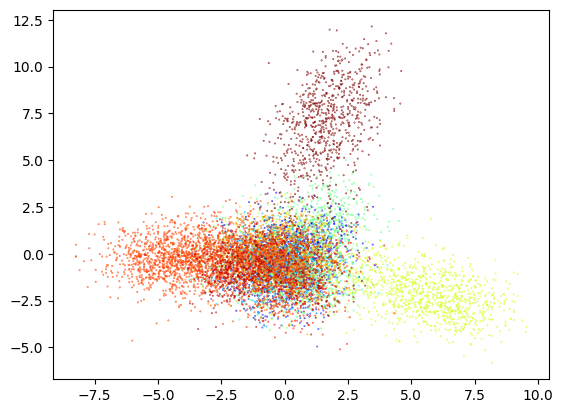

In [ ]:

plt.scatter(*c.T,  color=class_colors, s=.1)

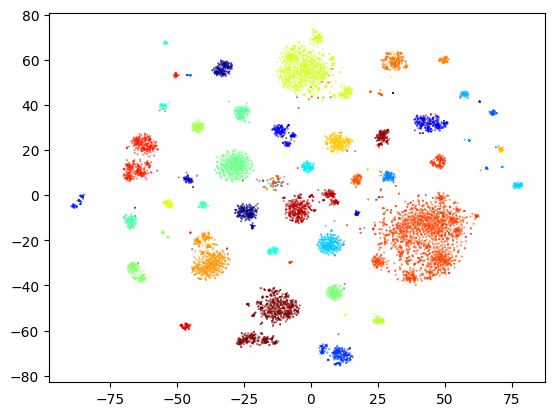

In [ ]:
plt.scatter(*b.T,  color=class_colors, s=.1)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming `similarity_matrix`, `labels`, and `centroid_labels` are already defined

# Create the plot
# plt.figure(figsize=(20, 60))  # Adjust the size to handle the large matrix
ax = sns.heatmap(np.log10(np.abs(similarity_matrix)), cmap='viridis', xticklabels=embeddings.keys(), yticklabels=False)
ax.set_title('Cosine Similarity Between Embeddings and Centroids')
ax.set_xlabel('Centroids')
ax.set_ylabel('Embeddings')
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'keys'

(array([    0., 10000., 20000., 30000., 40000., 50000., 60000., 70000.]),
 [Text(0, 0.0, '0'),
  Text(0, 10000.0, '10000'),
  Text(0, 20000.0, '20000'),
  Text(0, 30000.0, '30000'),
  Text(0, 40000.0, '40000'),
  Text(0, 50000.0, '50000'),
  Text(0, 60000.0, '60000'),
  Text(0, 70000.0, '70000')])

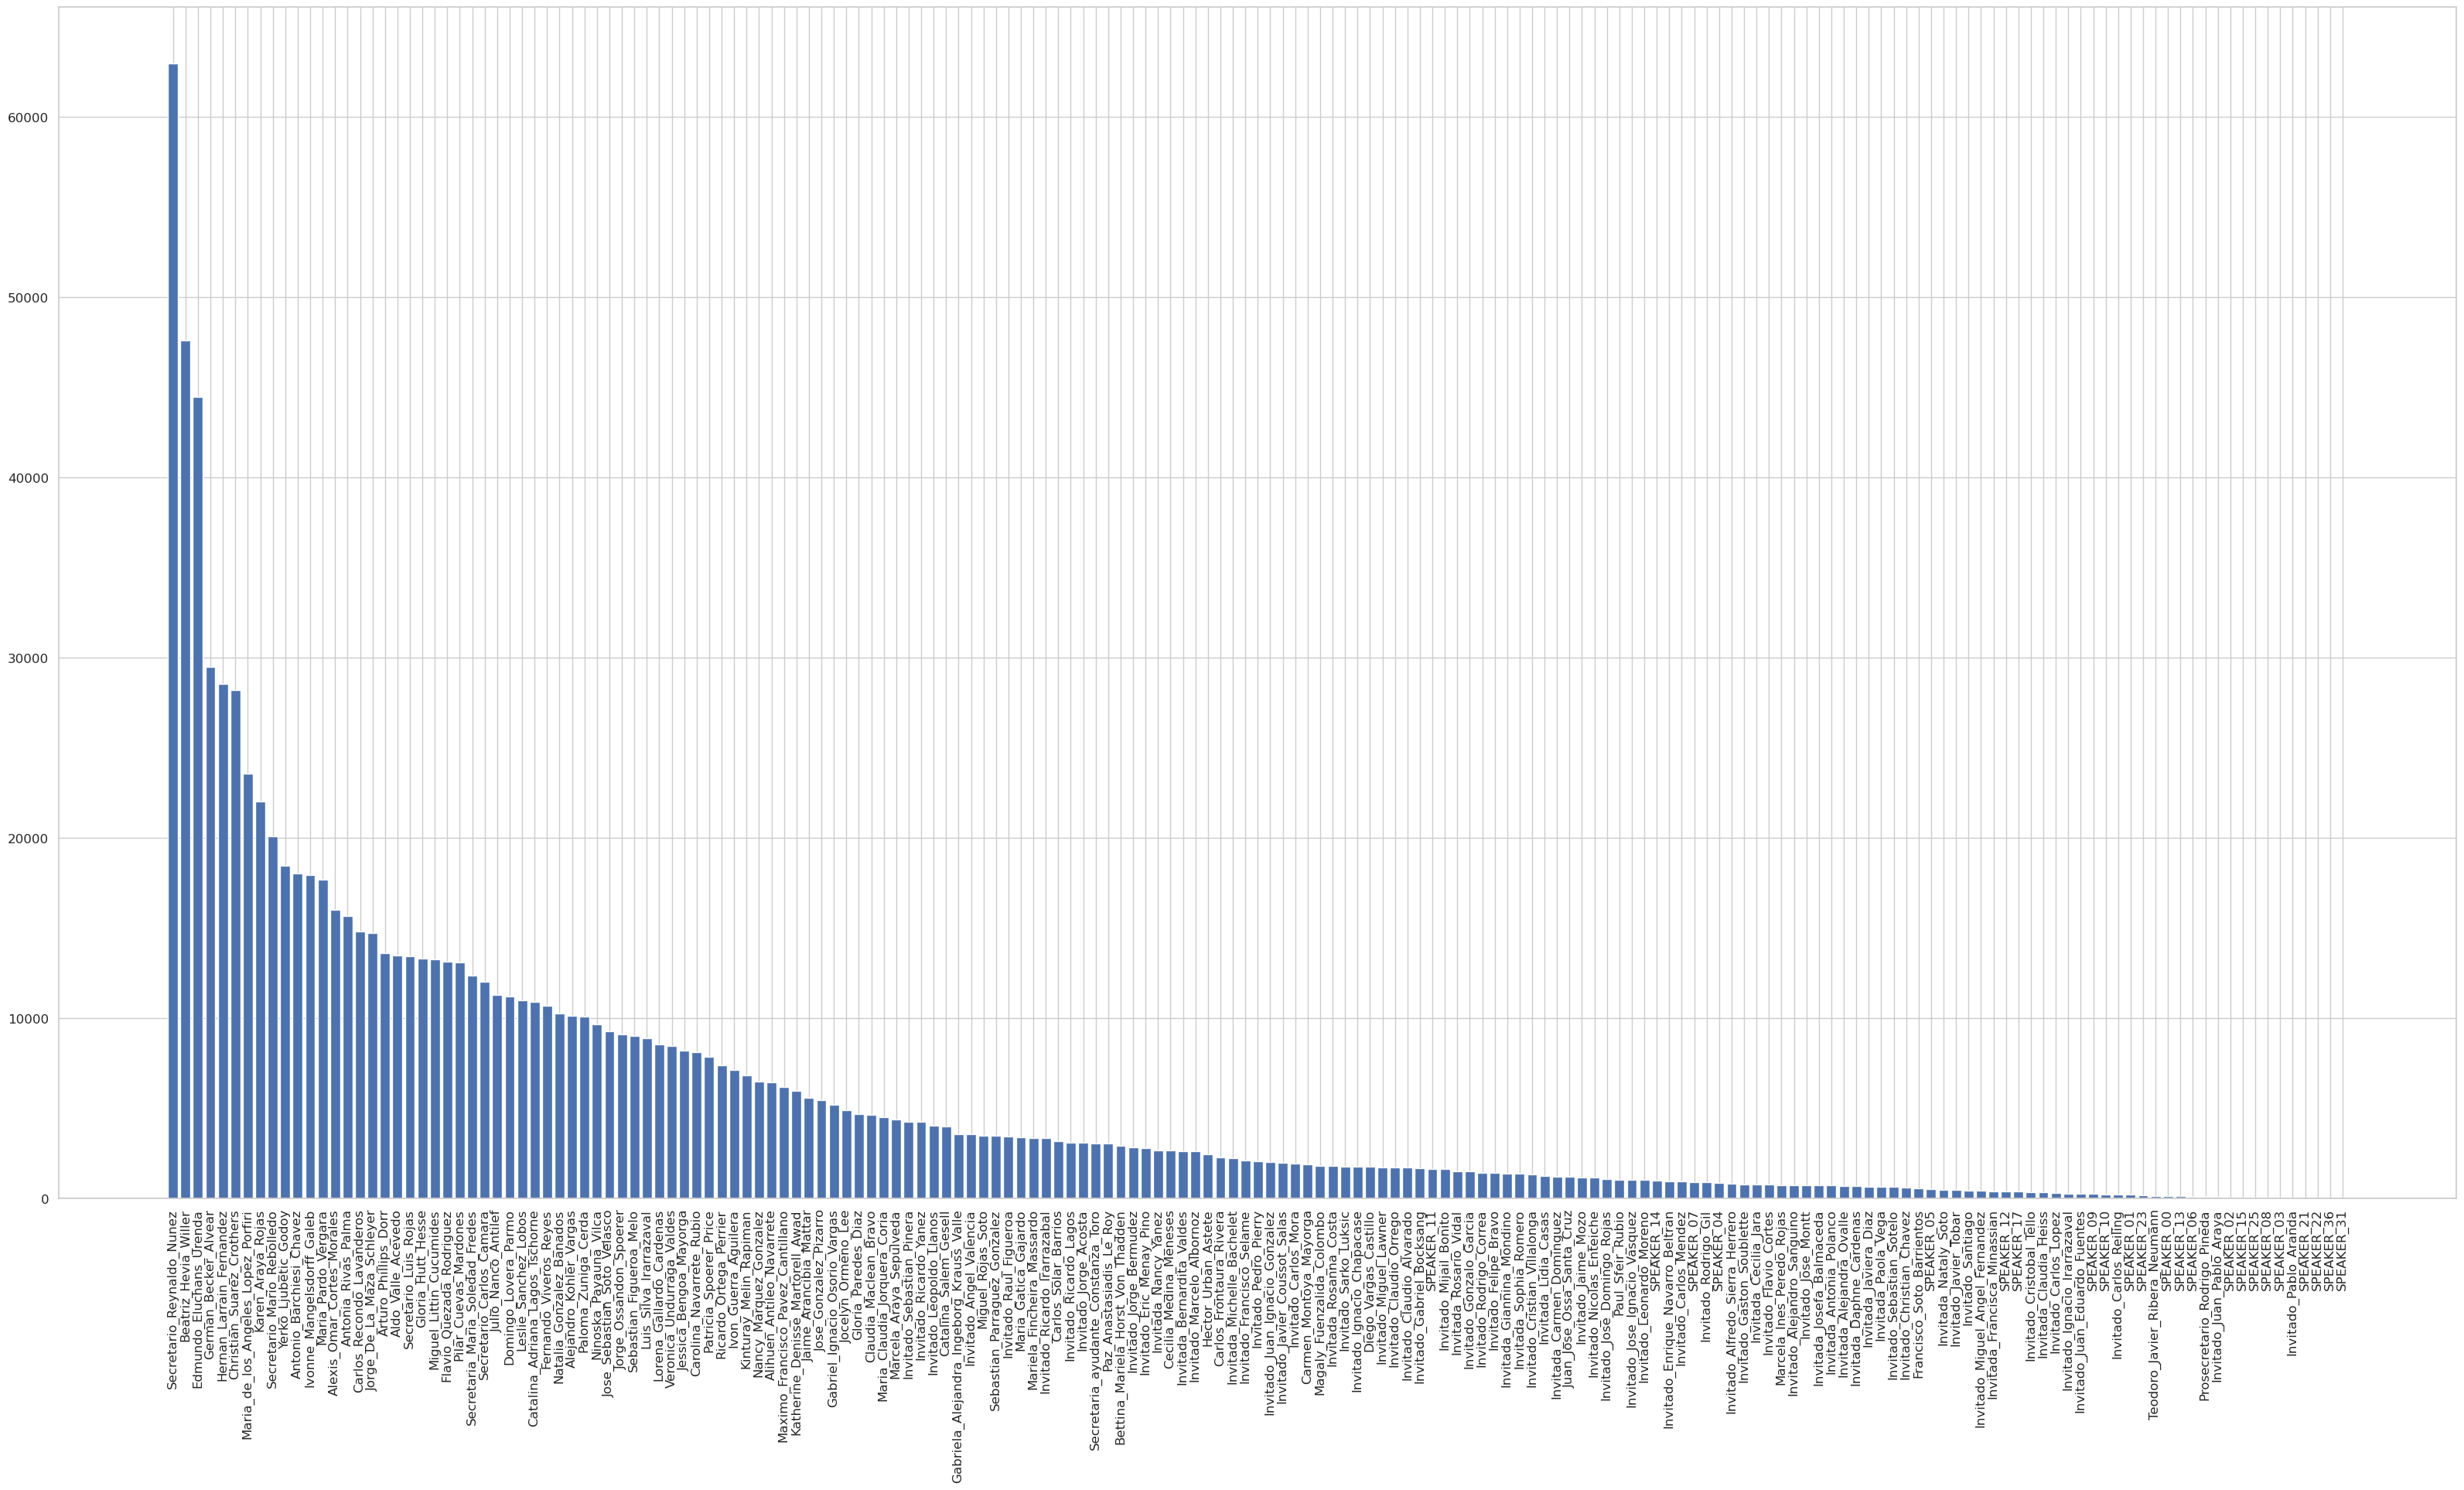

In [ ]:
import json
import seaborn as sns
import matplotlib.pyplot as plt

json_path = '/home/edu/ds-hear-module/speakers.json'

with open(json_path, 'r') as json_file:
    speakers = json.load(json_file)

x = list(speakers.keys())
y = [sum(speakers[speaker].values()) for speaker in x]

# Pair x and y, sort by y, then unzip
paired = zip(x, y)
sorted_pairs = sorted(paired, key=lambda item: item[1], reverse=True)

# Unzip the pairs
x_sorted, y_sorted = zip(*sorted_pairs)

# Convert the tuples back to lists, if needed
x_sorted = list(x_sorted)
y_sorted = list(y_sorted)

sns.set(style="whitegrid")
plt.figure(figsize=(40, 20))
plt.bar(x_sorted, y_sorted)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)

In [ ]:
import pandas as pd

pd.set_option('display.max_rows', 180)
df = pd.DataFrame({'speaker': x_sorted, 'count': y_sorted})

# Removing guests and unlabeled speakers
# mask = df['speaker'].str.contains('vitad', case=False, na=False) | df['speaker'].str.contains('SPEAKER', case=False, na=False)  
mask = df['speaker'].str.contains('SPEAKER', case=False, na=False)  
# Use the mask to filter out the rows
df_filtered = df[~mask]

df_filtered.reset_index(inplace=True, drop=True)

df_filtered

speaker  count
0                   Secretario_Reynaldo_Nunez  62943
1                        Beatriz_Hevia_Willer  47591
2                     Edmundo_Eluchans_Urenda  44471
3                        German_Becker_Alvear  29469
4                    Hernan_Larrain_Fernandez  28534
5                   Christian_Suarez_Crothers  28194
6          Maria_de_los_Angeles_Lopez_Porfiri  23580
7                           Karen_Araya_Rojas  22010
8                  Secretario_Mario_Rebolledo  20101
9                        Yerko_Ljubetic_Godoy  18463
10                   Antonio_Barchiesi_Chavez  18021
11                  Ivonne_Mangelsdorff_Galeb  17941
12                        Maria_Pardo_Vergara  17681
13                 Alexis_Omar_Cortes_Morales  15995
14                        Antonia_Rivas_Palma  15675
15                  Carlos_Recondo_Lavanderos  14818
16                  Jorge_De_La_Maza_Schleyer  14729
17                       Arturo_Phillips_Dorr  13620
18                         Aldo_Valle_Acevedo  13466
19                      Secretario_Luis_Rojas  13425
20                          Gloria_Hutt_Hesse  13309
21                    Miguel_Littin_Cucumides  13242
22                   Flavio_Quezada_Rodriguez  13139
23                      Pilar_Cuevas_Mardones  13102
24            Secretaria_Maria_Soledad_Fredes  12378
25                   Secretario_Carlos_Camara  12040
26                        Julio_Nanco_Antilef  11296
27                       Domingo_Lovera_Parmo  11216
28                       Leslie_Sanchez_Lobos  11005
29            Catalina_Adriana_Lagos_Tschorne  10903
30                     Fernando_Viveros_Reyes  10697
31                   Natalia_Gonzalez_Banados  10256
32                    Alejandro_Kohler_Vargas  10113
33                        Paloma_Zuniga_Cerda  10067
34                      Ninoska_Payauna_Vilca   9638
35                Jose_Sebastian_Soto_Velasco   9256
36                     Jorge_Ossandon_Spoerer   9090
37                    Sebastian_Figueroa_Melo   9003
38                     Luis_Silva_Irarrazaval   8907
39                   Lorena_Gallardo_Cardenas   8532
40                  Veronica_Undurraga_Valdes   8447
41                     Jessica_Bengoa_Mayorga   8183
42                   Carolina_Navarrete_Rubio   8130
43                     Patricia_Spoerer_Price   7835
44                     Ricardo_Ortega_Perrier   7391
45                       Ivon_Guerra_Aguilera   7129
46                     Kinturay_Melin_Rapiman   6821
47                     Nancy_Marquez_Gonzalez   6477
48                  Alihuen_Antileo_Navarrete   6429
49          Maximo_Francisco_Pavez_Cantillano   6169
50           Katherine_Denisse_Martorell_Awad   5959
51                     Jaime_Arancibia_Mattar   5588
52                      Jose_Gonzalez_Pizarro   5443
53              Gabriel_Ignacio_Osorio_Vargas   5179
54                         Jocelyn_Ormeno_Lee   4876
55                        Gloria_Paredes_Diaz   4689
56                      Claudia_Maclean_Bravo   4650
57               Maria_Claudia_Jorquera_Coria   4521
58                    Marcela_Araya_Sepulveda   4380
59                  Invitado_Sebastian_Pinera   4266
60                     Invitado_Ricardo_Yanez   4246
61                   Invitado_Leopoldo_Llanos   4040
62                      Catalina_Salem_Gesell   4012
63   Gabriela_Alejandra_Ingeborg_Krauss_Valle   3582
64                    Invitado_Angel_Valencia   3545
65                          Miguel_Rojas_Soto   3490
66               Sebastian_Parraguez_Gonzalez   3476
67                     Invitado_Raul_Figueroa   3435
68                       Maria_Gatica_Gajardo   3373
69                 Mariela_Fincheira_Massardo   3364
70               Invitado_Ricardo_Irarrazabal   3342
71                       Carlos_Solar_Barrios   3176
72                     Invitado_Ricardo_Lagos   3088
73                      Invitado_Jorge_Acosta   3087
74         Secretaria_ayudante_Constanza_Toro   3059
75        

In [ ]:
import os

audio_dir = '/home/edu/data/raw_audios'
label_dir = '/home/edu/data/labels/backup-cnn/speaker/consejo_constitucional_clean'

audios = os.listdir(audio_dir)
labels = os.listdir(label_dir)

audios = [audio.split('.')[0] for audio in audios]
labels = [label.split('.')[0] for label in labels]

audios.sort()
labels.sort()

print(f'Number of audios: {len(audios)}')
print(f'Number of labels: {len(labels)}')


Number of audios: 68
Number of labels: 68


In [ ]:
# Convert lists to sets
set_audios = set(audios)
set_labels = set(labels)

# Find elements in a but not in b
only_in_audios = set_audios - set_labels

# Find elements in b but not in a
only_in_labels = set_labels - set_audios

# Convert the sets back to lists (if needed)
only_in_audios = list(only_in_audios)
only_in_labels = list(only_in_labels)

only_in_audios.sort()
only_in_labels.sort()

print("Only in audios:")
for item in only_in_audios:
    print(item)

print("Only in labels:")
for item in only_in_labels:
    print(item)
    

Only in audios:
Only in labels:


Secreatrio_Mario_Rebolledo, Secretario_Mario_Rebolledo
